# Library

In [4]:
import json
from collections import Counter, defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tiktoken
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import f1_score

import os

Compute output tokens 

In [3]:
def compute_output_tokens(row, original_reviews, model, index_field=None):
    index = row.name if not index_field else row[index_field]

    if not row['is_state_of_art']:
        return 0

    try:
        full_text = ''.join(original_reviews.at[index, 'review'] + original_reviews.at[index, 'review_bpc'])
        return count_raw_tokens(full_text, model)
    except KeyError:
        return 0

Compute input tokens

In [4]:
def compute_input_tokens(row, original_reviews, model, index_field=None):
    index = row.name if not index_field else row[index_field]

    if not row['is_state_of_art']:
        return 0
    try:
        prompt_text = gen_prompt(row['question_text'], row['text_vicuna'], row['text_gpt'])
        n_outputs = len(original_reviews.at[index, 'review']) + len(original_reviews.at[index, 'review_bpc'])
        return count_raw_tokens(prompt_text, model) * n_outputs
    except KeyError:
        return 0

Get top `ratio` indexes

In [5]:
def get_top_half_indices(relia_scores, ratio=0.5):
    sorted_indices = np.argsort(-np.array(relia_scores))
    top_half_indices = sorted_indices[:int(len(sorted_indices) * ratio)]

    return list(top_half_indices)

Function that generates prompt

In [6]:
def gen_prompt(question, first_answer, second_answer):
    sys_prompt = 'You are a helpful and precise assistant for checking the quality of the answer.'
    prompt_template = "[Question]\n{question}\n\n[The Start of Assistant 1's Answer]\n{answer_1}\n[The End of Assistant 1's Answer]\n\n[The Start of Assistant 2's Answer]\n{answer_2}\n[The End of Assistant 2's Answer]\n\n[System]\n{prompt}\n"
    default_prompt = """We would like to request your feedback on the performance of two AI assistants in response to the user question displayed above.
    Please rate the helpfulness, relevance, accuracy, level of details of their responses. 

    Each assistant receives an overall score on a scale of 1 to 10, where a higher score indicates better overall performance.
    Please first provide a comprehensive explanation of your evaluation, avoiding any potential bias and ensuring that the order in which the responses were presented does not affect your judgment. 
    Then, output two lines indicating the scores for Assistant 1 and 2, respectively.

    Output with the following format:
    Evaluation evidence: <your evaluation explanation here>
    Score of the Assistant 1: <score>
    Score of the Assistant 2: <score>"""
    return sys_prompt, prompt_template.format(question=question, answer_1=first_answer, answer_2=second_answer,
                                              prompt=default_prompt)

Function that calculates amount of tokens in messages

In [7]:
def count_raw_tokens(messages, model="gpt-3.5-turbo"):
    try:
        encoding = tiktoken.encoding_for_model(model)
    except KeyError:
        encoding = tiktoken.get_encoding("cl100k_base")

    num_tokens = 0
    for message in messages:
        num_tokens += len(encoding.encode(message))
    return num_tokens

Compute mean cost and mean score

In [8]:
def most_common_label(labels):
    counter = Counter(labels)
    return counter.most_common(1)[0][0]


def aggregate(group, win_label="CHATGPT", lose_label="VICUNA13B", tie_label="TIE"):
    score_arrays = np.stack(group['score'])
    results = []

    for score in score_arrays:
        current_result = win_label if score[0] > score[1] else lose_label if score[0] < score[1] else tie_label
        results.append(current_result)

    final_result = most_common_label(results)

    row = group.iloc[0].copy()
    row['result'] = final_result

    if all(col in group.columns for col in ['input_tokens', 'output_tokens']):
        row['input_tokens'] = group['input_tokens'].sum()
        row['output_tokens'] = group['output_tokens'].sum()

    return row

Function that plots the bars of accuracy between 2 preset of parameters

In [9]:
def plot_grouped_accuracy_bars(first_results: pd.Series, second_results: pd.Series, first_label, second_label):
    """
    Plots a grouped bar chart comparing accuracy between two models from two pd.Series.

    Args:
        first_results (pd.Series): First series with index as categories and values as accuracy.
        second_results (pd.Series): Second series with the same structure.
        first_label (str): Label for the first series.
        second_label (str): Label for the second series.
    """
    # Align indexes just in case
    common_index = first_results.index.intersection(second_results.index)

    first_values = first_results.loc[common_index].values
    second_values = second_results.loc[common_index].values

    categories = common_index.tolist()

    x = np.arange(len(categories))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))

    bars1 = ax.bar(x - width / 2, first_values, width, label=first_label, hatch='///', color='skyblue',
                   edgecolor='black')
    bars2 = ax.bar(x + width / 2, second_values, width, label=second_label, hatch='\\\\\\', color='lightcoral',
                   edgecolor='black')

    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

    ax.set_ylabel('Accuracy', fontsize=13)
    ax.set_ylim(0, 1.05)
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Check mean accuracy and kappa coefficient
In this chapter we recheck the results gained from the repeated experiments to check the similarity of:
- mean **accuracy** with labels provided by the humans
- **kappa correlation coefficient** with ground-truth (labels from the humans)  

Read the questions and remain only their `category`

In [10]:
questions = pd.read_json('question.jsonl', lines=True)
questions = questions.set_index('question_id').drop(['text'], axis=1)
questions

,category
question_id,
1,generic
2,generic
3,generic
4,generic
5,generic
...,...
76,writing
77,writing
78,writing


Read and merge the results of human assessing as `ground_truth` for the further calculations 

In [11]:
with open('./review/review_gpt35_vicuna-13b_human.txt', 'r', encoding='utf-8') as f:
    text_lines = f.read().splitlines()

len(text_lines)

80

In [12]:
questions['ground_truth'] = text_lines
questions

,category,ground_truth
question_id,,
1,generic,CHATGPT
2,generic,TIE
3,generic,VICUNA13B
4,generic,VICUNA13B
5,generic,VICUNA13B
...,...,...
76,writing,CHATGPT
77,writing,CHATGPT
78,writing,CHATGPT


Read the results of experiments into one 

In [13]:
AMOUNT_OF_EXPERIMENTS = 4

result_list = []

In [14]:
for i in range(1, AMOUNT_OF_EXPERIMENTS + 1):
    current_judgement_result = {
        'gpt4_k_1_bpc_0_t_1': pd.read_json(f'review/{i}/review_gpt35_vicuna-13b_gpt-4_mec1_bpc0.jsonl',
                                           lines=True).set_index(
            'question_id'),
        'gpt4_k_6_bpc_0_t_1': pd.read_json(f'review/{i}/review_gpt35_vicuna-13b_gpt-4_mec6_bpc0.jsonl',
                                           lines=True).set_index(
            'question_id'),
        'gpt4_k_3_bpc_1_t_1': pd.read_json(f'review/{i}/review_gpt35_vicuna-13b_gpt-4_mec3_bpc1.jsonl',
                                           lines=True).set_index(
            'question_id'),
        'gpt35_k_1_bpc_0_t_1': pd.read_json(f'review/{i}/review_gpt35_vicuna-13b_gpt-3.5-turbo_mec1_bpc0.jsonl',
                                            lines=True).set_index(
            'question_id'),
        'gpt35_k_3_bpc_0_t_1': pd.read_json(f'review/{i}/review_gpt35_vicuna-13b_gpt-3.5-turbo_mec3_bpc0.jsonl',
                                            lines=True).set_index(
            'question_id'),
        'gpt35_k_6_bpc_0_t_1': pd.read_json(f'review/{i}/review_gpt35_vicuna-13b_gpt-3.5-turbo_mec6_bpc0.jsonl',
                                            lines=True).set_index(
            'question_id'),
        'gpt35_k_3_bpc_1_t_1': pd.read_json(f'review/{i}/review_gpt35_vicuna-13b_gpt-3.5-turbo_mec3_bpc1.jsonl',
                                            lines=True).set_index(
            'question_id'),
    }

    result_list.append(current_judgement_result)

result_list[0]['gpt4_k_1_bpc_0_t_1']

,question,review,review_bpc,cost,score
question_id,,,,,
1,How can I improve my time management skills?,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.03303,"[10.0, 9.5]"
2,What are the most effective ways to deal with ...,[Evaluation evidence: Both assistants provided...,[],0.02934,"[9.0, 10.0]"
3,What are the main differences between Python a...,[Evaluation evidence: Both Assistant 1 and 2 p...,[],0.03099,"[10.0, 9.0]"
4,How can I increase my productivity while worki...,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.03237,"[9.0, 9.0]"
5,Can you explain the basics of quantum computing?,[Evaluation evidence: Both assistants effectiv...,[],0.03276,"[9.5, 9.5]"
...,...,...,...,...,...
76,Write a script for a YouTube video exploring t...,[Evaluation evidence: Both assistants did an e...,[],0.03945,"[10.0, 9.0]"
77,Compose an engaging travel blog post about a r...,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.04443,"[9.5, 9.0]"
78,Write a captivating movie review for a recentl...,[Evaluation evidence: Both assistants provided...,[],0.03279,"[9.0, 8.5]"


Extract **winner** of judgement:
* if the `first score > second score` -> CHATGPT
* if the `first score < second score` -> VICUNA13B
* if the `first score == second score` -> TIE

In [15]:
judgement_result = {}

for key in result_list[0].keys():
    # Stack DataFrames across experiments
    dfs = [res[key] for res in result_list]
    combined_df = pd.concat(dfs).groupby('question_id')

    judgement_result[key] = combined_df.apply(aggregate)
    judgement_result[key]['ground_truth'] = questions['ground_truth']
    judgement_result[key]['category'] = questions['category']

judgement_result['gpt4_k_1_bpc_0_t_1']

,question,review,review_bpc,cost,score,result,ground_truth,category
question_id,,,,,,,,
1,How can I improve my time management skills?,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.03303,"[10.0, 9.5]",CHATGPT,CHATGPT,generic
2,What are the most effective ways to deal with ...,[Evaluation evidence: Both assistants provided...,[],0.02934,"[9.0, 10.0]",VICUNA13B,TIE,generic
3,What are the main differences between Python a...,[Evaluation evidence: Both Assistant 1 and 2 p...,[],0.03099,"[10.0, 9.0]",CHATGPT,VICUNA13B,generic
4,How can I increase my productivity while worki...,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.03237,"[9.0, 9.0]",TIE,VICUNA13B,generic
5,Can you explain the basics of quantum computing?,[Evaluation evidence: Both assistants effectiv...,[],0.03276,"[9.5, 9.5]",TIE,VICUNA13B,generic
...,...,...,...,...,...,...,...,...
76,Write a script for a YouTube video exploring t...,[Evaluation evidence: Both assistants did an e...,[],0.03945,"[10.0, 9.0]",CHATGPT,CHATGPT,writing
77,Compose an engaging travel blog post about a r...,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.04443,"[9.5, 9.0]",CHATGPT,CHATGPT,writing
78,Write a captivating movie review for a recentl...,[Evaluation evidence: Both assistants provided...,[],0.03279,"[9.0, 8.5]",CHATGPT,CHATGPT,writing


Create **flag** == `ground_truth` == `win_res` for accuracy calculations

In [16]:
for df in judgement_result.values():
    df['result_hit'] = df['ground_truth'] == df['result']

judgement_result['gpt4_k_1_bpc_0_t_1']

,question,review,review_bpc,cost,score,result,ground_truth,category,result_hit
question_id,,,,,,,,,
1,How can I improve my time management skills?,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.03303,"[10.0, 9.5]",CHATGPT,CHATGPT,generic,True
2,What are the most effective ways to deal with ...,[Evaluation evidence: Both assistants provided...,[],0.02934,"[9.0, 10.0]",VICUNA13B,TIE,generic,False
3,What are the main differences between Python a...,[Evaluation evidence: Both Assistant 1 and 2 p...,[],0.03099,"[10.0, 9.0]",CHATGPT,VICUNA13B,generic,False
4,How can I increase my productivity while worki...,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.03237,"[9.0, 9.0]",TIE,VICUNA13B,generic,False
5,Can you explain the basics of quantum computing?,[Evaluation evidence: Both assistants effectiv...,[],0.03276,"[9.5, 9.5]",TIE,VICUNA13B,generic,False
...,...,...,...,...,...,...,...,...,...
76,Write a script for a YouTube video exploring t...,[Evaluation evidence: Both assistants did an e...,[],0.03945,"[10.0, 9.0]",CHATGPT,CHATGPT,writing,True
77,Compose an engaging travel blog post about a r...,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.04443,"[9.5, 9.0]",CHATGPT,CHATGPT,writing,True
78,Write a captivating movie review for a recentl...,[Evaluation evidence: Both assistants provided...,[],0.03279,"[9.0, 8.5]",CHATGPT,CHATGPT,writing,True


Calculate `accuracy` (percentage of matches between ground-truth and judgement) in the map

In [17]:
accuracy_map = {}

for idx, df in judgement_result.items():
    accuracy_map[idx] = df["result_hit"].mean() * 100

accuracy_map

{'gpt4_k_1_bpc_0_t_1': np.float64(62.5),
 'gpt4_k_6_bpc_0_t_1': np.float64(65.0),
 'gpt4_k_3_bpc_1_t_1': np.float64(61.25000000000001),
 'gpt35_k_1_bpc_0_t_1': np.float64(63.74999999999999),
 'gpt35_k_3_bpc_0_t_1': np.float64(65.0),
 'gpt35_k_6_bpc_0_t_1': np.float64(60.0),
 'gpt35_k_3_bpc_1_t_1': np.float64(61.25000000000001)}

Calculate `kappa correlation coefficient` in the map

In [18]:
kappa_map = {}

for idx, df in judgement_result.items():
    kappa_map[idx] = cohen_kappa_score(df["ground_truth"], df["result"])

kappa_map

{'gpt4_k_1_bpc_0_t_1': np.float64(0.3702440304382052),
 'gpt4_k_6_bpc_0_t_1': np.float64(0.3913043478260869),
 'gpt4_k_3_bpc_1_t_1': np.float64(0.34512806971217325),
 'gpt35_k_1_bpc_0_t_1': np.float64(0.3778492893537141),
 'gpt35_k_3_bpc_0_t_1': np.float64(0.3886462882096069),
 'gpt35_k_6_bpc_0_t_1': np.float64(0.2920353982300885),
 'gpt35_k_3_bpc_1_t_1': np.float64(0.35601142560373933)}

## Drawing conclusions

Define description map for every preset of parameters

In [19]:
DESCRIPTION_MAP = {
    'gpt4_k_1_bpc_0_t_1': {
        'judge': 'GPT-4',
        'description': 'EC (k = 1)'
    },
    'gpt4_k_6_bpc_0_t_1': {
        'judge': 'GPT-4',
        'description': 'MEC (k = 6)'
    },
    'gpt4_k_3_bpc_1_t_1': {
        'judge': 'GPT-4',
        'description': 'MEC (k = 3) + BPC (k = 3)'
    },
    'gpt35_k_1_bpc_0_t_1': {
        'judge': 'GPT-3.5',
        'description': 'EC (k = 1)'
    },
    'gpt35_k_3_bpc_0_t_1': {
        'judge': 'GPT-3.5',
        'description': 'MEC (k = 3)'
    },
    'gpt35_k_6_bpc_0_t_1': {
        'judge': 'GPT-3.5',
        'description': 'MEC (k = 6)'
    },
    'gpt35_k_3_bpc_1_t_1': {
        'judge': 'GPT-3.5',
        'description': 'MEC (k = 3) + BPC (k = 3)'
    },
}

Create a final judgement table

In [20]:
final_table = pd.DataFrame({
    "judge": [v["judge"] for v in DESCRIPTION_MAP.values()],
    "description": [v["description"] for v in DESCRIPTION_MAP.values()],
    "accuracy": accuracy_map.values(),
    "kappa": kappa_map.values(),
}, index=accuracy_map.keys())

final_table

,judge,description,accuracy,kappa
gpt4_k_1_bpc_0_t_1,GPT-4,EC (k = 1),62.50,0.370244
gpt4_k_6_bpc_0_t_1,GPT-4,MEC (k = 6),65.00,0.391304
gpt4_k_3_bpc_1_t_1,GPT-4,MEC (k = 3) + BPC (k = 3),61.25,0.345128
gpt35_k_1_bpc_0_t_1,GPT-3.5,EC (k = 1),63.75,0.377849
gpt35_k_3_bpc_0_t_1,GPT-3.5,MEC (k = 3),65.00,0.388646
gpt35_k_6_bpc_0_t_1,GPT-3.5,MEC (k = 6),60.00,0.292035
gpt35_k_3_bpc_1_t_1,GPT-3.5,MEC (k = 3) + BPC (k = 3),61.25,0.356011


![Paper results](./fig/first_experiment.png)

# Check categories accuracy
In this chapter I try to repeat check for the results between different **categories** of questions

Two preset are going to be compared:
1. **EC (k = 1)** - the worst option except for Vanilla (according to paper)
2. **MEC (k = 3) + BPC (k = 3)** - the best option without human participation (according to paper)

In [21]:
BEST_PARAMETERS_SET = 'k_3_bpc_1_t_1'

In [22]:
WORST_PARAMETERS_SET = 'k_1_bpc_0_t_1'

## GPT-4
Extract accuracy grouped by categories in the worst and best cases for **GPT-4**

In [23]:
gpt4_best_category_acc = judgement_result[f"gpt4_{BEST_PARAMETERS_SET}"].groupby('category')['result_hit'].mean()
gpt4_best_category_acc

category
coding            0.714286
common-sense      0.600000
counterfactual    0.400000
fermi             0.600000
generic           0.700000
knowledge         0.500000
math              0.666667
roleplay          0.600000
writing           0.800000
Name: result_hit, dtype: float64

In [24]:
gpt4_worst_category_acc = judgement_result[f"gpt4_{WORST_PARAMETERS_SET}"].groupby('category')['result_hit'].mean()

gpt4_worst_category_acc

category
coding            1.000000
common-sense      0.800000
counterfactual    0.500000
fermi             0.600000
generic           0.400000
knowledge         0.300000
math              0.666667
roleplay          0.600000
writing           0.900000
Name: result_hit, dtype: float64

Plot the same chart as in the paper

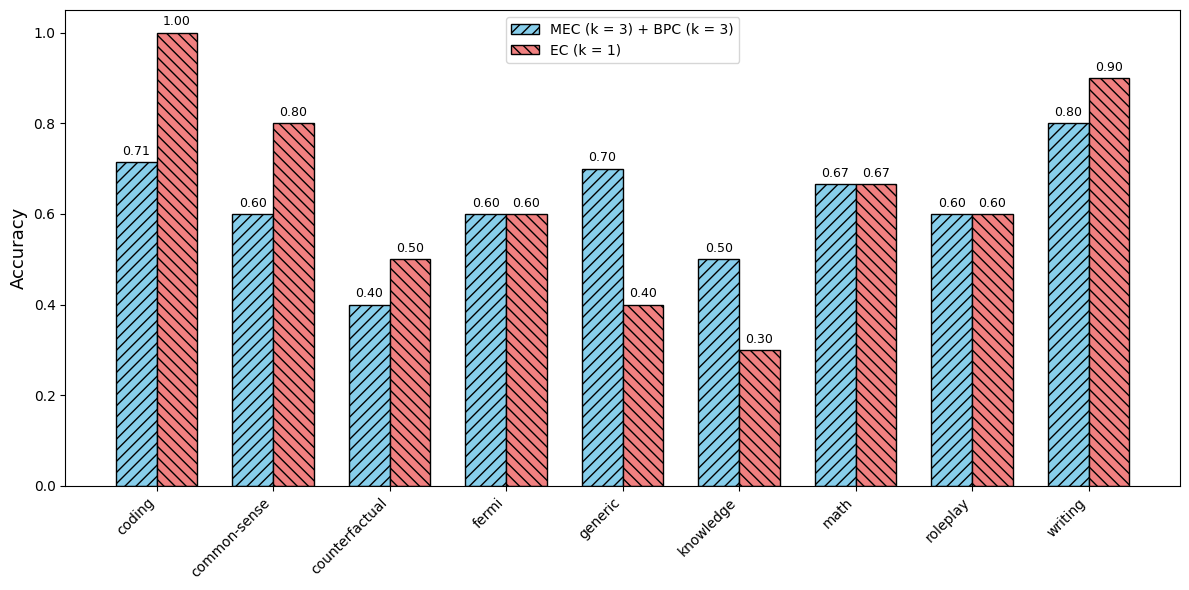

In [25]:
plot_grouped_accuracy_bars(gpt4_best_category_acc, gpt4_worst_category_acc, second_label="EC (k = 1)",
                           first_label='MEC (k = 3) + BPC (k = 3)')

![Paper results](./fig/gpt4_categories.png)

## GPT 3.5
Calculate the accuracy across categories for GPT 3.5

In [26]:
gpt3_5_best_category_acc = judgement_result[f"gpt35_{BEST_PARAMETERS_SET}"].groupby('category')['result_hit'].mean()

gpt3_5_best_category_acc

category
coding            0.857143
common-sense      0.600000
counterfactual    0.500000
fermi             0.400000
generic           0.600000
knowledge         0.600000
math              0.666667
roleplay          0.600000
writing           0.800000
Name: result_hit, dtype: float64

In [27]:
gpt3_5_worst_category_acc = judgement_result[f"gpt35_{WORST_PARAMETERS_SET}"].groupby('category')['result_hit'].mean()

gpt3_5_worst_category_acc

category
coding            0.714286
common-sense      0.700000
counterfactual    0.500000
fermi             0.600000
generic           0.600000
knowledge         0.500000
math              1.000000
roleplay          0.600000
writing           0.800000
Name: result_hit, dtype: float64

Plot the same chart as in the paper

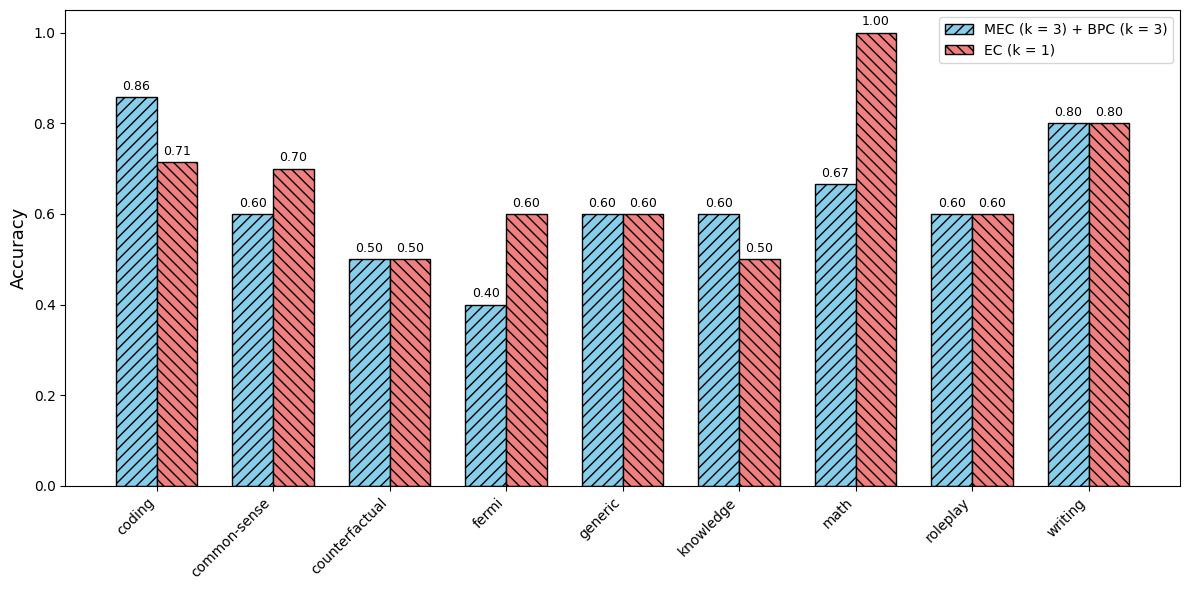

In [28]:
plot_grouped_accuracy_bars(gpt3_5_best_category_acc, gpt3_5_worst_category_acc, second_label="EC (k = 1)",
                           first_label='MEC (k = 3) + BPC (k = 3)')

![Paper results](./fig/gpt3_5_categories.png)

# Sampled results

## Check mean accuracy and kappa coefficient

Find all the directories names 

In [29]:
SAMPLED_RESULTS_PATH = "./sampled_review"

In [30]:
dirs = [int(name) for name in os.listdir(SAMPLED_RESULTS_PATH) if
        os.path.isdir(os.path.join(SAMPLED_RESULTS_PATH, name))]
dirs.sort()
dirs.pop()
dirs

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46]

In [31]:
sampled_result_list = []

for it in dirs:
    current_judgement_result = {
        'gpt35_k_1_bpc_0_t_1': pd.read_json(f'./sampled_review/{it}/review_gpt35_vicuna_gpt-3.5-turbo_mec1_bpc0.jsonl',
                                            lines=True).set_index(
            'question_id'),
        'gpt4_k_1_bpc_0_t_1': pd.read_json(f'./sampled_review/{it}/review_gpt35_vicuna_gpt-4_mec1_bpc0.jsonl',
                                           lines=True).set_index(
            'question_id'),
        'gpt35_k_3_bpc_1_t_1': pd.read_json(f'./sampled_review/{it}/review_gpt35_vicuna_gpt-3.5-turbo_mec3_bpc1.jsonl',
                                            lines=True).set_index(
            'question_id'),
        'gpt4_k_3_bpc_1_t_1': pd.read_json(f'./sampled_review/{it}/review_gpt35_vicuna_gpt-4_mec3_bpc1.jsonl',
                                           lines=True).set_index(
            'question_id'),
    }

    sampled_result_list.append(current_judgement_result)

sampled_result_list[0]['gpt4_k_1_bpc_0_t_1']

,question,review,review_bpc,cost,score
question_id,,,,,
7,How can I develop my critical thinking skills?,[Evaluation evidence: Both assistants provide ...,[],0.03069,"[9.0, 10.0]"
17,How do vaccinations work to protect individual...,[Evaluation evidence: Both assistants provided...,[],0.02739,"[9.0, 10.0]"
27,Pretend to be a world-famous chef. How would y...,[Evaluation evidence: Both Assistants indeed p...,[],0.03369,"[9.0, 8.0]"
38,How can observing the behavior of other people...,[Evaluation evidence: Both assistants provided...,[],0.02733,"[10.0, 9.0]"
45,How many text messages are sent globally in a ...,[Evaluation evidence: Assistant 1 provided spe...,[],0.03066,"[8.0, 6.0]"
57,What if the Suez Canal had never been construc...,[Evaluation evidence: Both assistants provide ...,[],0.02703,"[9.0, 10.0]"
66,Implement a queue data structure using two sta...,[Evaluation evidence: Assistant 1’s answer is ...,[],0.03774,"[10.0, 2.0]"
69,Solve for x in the equation 3x + 10 = 5(x - 2).,[Evaluation evidence: Assistant 1's explanatio...,[],0.02946,"[10.0, 2.0]"
76,Write a script for a YouTube video exploring t...,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.04125,"[9.0, 8.5]"


In [32]:
for idx, key in enumerate(sampled_result_list[0].keys()):
    model = 'gpt-4' if 'gpt4' in key else 'gpt-3.5-turbo'

    for res in sampled_result_list:
        df = res[key]

        sampled_vicuna_answers = pd.read_json(f'./sampled/answer_vicuna/{idx}.jsonl', lines=True).set_index(
            'question_id')
        sampled_gpt35_answers = pd.read_json(f'./sampled/answer_gpt35/{idx}.jsonl', lines=True).set_index(
            'question_id')

        df['input_tokens'] = df.apply(
            lambda row: count_raw_tokens(
                gen_prompt(
                    row['question'],
                    sampled_vicuna_answers.at[row.name, 'text'],
                    sampled_gpt35_answers.at[row.name, 'text']
                ),
                model
            ) * (len(row['review']) + len(row['review_bpc'])), axis=1)

        df['output_tokens'] = df.apply(lambda row: count_raw_tokens(''.join(row['review'] + row['review_bpc']), model),
                                       axis=1)

sampled_result_list[0]['gpt4_k_1_bpc_0_t_1']

,question,review,review_bpc,cost,score,input_tokens,output_tokens
question_id,,,,,,,
7,How can I develop my critical thinking skills?,[Evaluation evidence: Both assistants provide ...,[],0.03069,"[9.0, 10.0]",710,832
17,How do vaccinations work to protect individual...,[Evaluation evidence: Both assistants provided...,[],0.02739,"[9.0, 10.0]",670,620
27,Pretend to be a world-famous chef. How would y...,[Evaluation evidence: Both Assistants indeed p...,[],0.03369,"[9.0, 8.0]",814,755
38,How can observing the behavior of other people...,[Evaluation evidence: Both assistants provided...,[],0.02733,"[10.0, 9.0]",666,661
45,How many text messages are sent globally in a ...,[Evaluation evidence: Assistant 1 provided spe...,[],0.03066,"[8.0, 6.0]",647,946
57,What if the Suez Canal had never been construc...,[Evaluation evidence: Both assistants provide ...,[],0.02703,"[9.0, 10.0]",608,757
66,Implement a queue data structure using two sta...,[Evaluation evidence: Assistant 1’s answer is ...,[],0.03774,"[10.0, 2.0]",847,840
69,Solve for x in the equation 3x + 10 = 5(x - 2).,[Evaluation evidence: Assistant 1's explanatio...,[],0.02946,"[10.0, 2.0]",641,687
76,Write a script for a YouTube video exploring t...,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.04125,"[9.0, 8.5]",948,1057


In [33]:
sampled_judgement_result = {}

for key in sampled_result_list[0].keys():
    # Stack DataFrames across experiments
    dfs = [res[key] for res in sampled_result_list]
    combined_df = pd.concat(dfs).groupby('question_id')

    sampled_judgement_result[key] = combined_df.apply(aggregate)

sampled_judgement_result['gpt4_k_1_bpc_0_t_1']

,question,review,review_bpc,cost,score,input_tokens,output_tokens,result
question_id,,,,,,,,
7,How can I develop my critical thinking skills?,[Evaluation evidence: Both assistants provide ...,[],0.03069,"[9.0, 10.0]",32660,38342,VICUNA13B
17,How do vaccinations work to protect individual...,[Evaluation evidence: Both assistants provided...,[],0.02739,"[9.0, 10.0]",30820,36575,VICUNA13B
27,Pretend to be a world-famous chef. How would y...,[Evaluation evidence: Both Assistants indeed p...,[],0.03369,"[9.0, 8.0]",37444,45674,CHATGPT
38,How can observing the behavior of other people...,[Evaluation evidence: Both assistants provided...,[],0.02733,"[10.0, 9.0]",30636,35925,CHATGPT
45,How many text messages are sent globally in a ...,[Evaluation evidence: Assistant 1 provided spe...,[],0.03066,"[8.0, 6.0]",29762,41808,CHATGPT
57,What if the Suez Canal had never been construc...,[Evaluation evidence: Both assistants provide ...,[],0.02703,"[9.0, 10.0]",27968,36595,VICUNA13B
66,Implement a queue data structure using two sta...,[Evaluation evidence: Assistant 1’s answer is ...,[],0.03774,"[10.0, 2.0]",38962,40139,CHATGPT
69,Solve for x in the equation 3x + 10 = 5(x - 2).,[Evaluation evidence: Assistant 1's explanatio...,[],0.02946,"[10.0, 2.0]",29486,34063,CHATGPT
76,Write a script for a YouTube video exploring t...,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.04125,"[9.0, 8.5]",43608,41725,CHATGPT


In [34]:
idx = 0

for file_idx, (name, df) in enumerate(sampled_judgement_result.items()):

    sampled_questions = pd.read_json(f'./sampled/questions/{file_idx}.jsonl', lines=True)
    sampled_questions = sampled_questions.set_index('question_id').drop(['text'], axis=1)

    for idx in sampled_questions.index:
        sampled_questions.at[idx, 'ground_truth'] = text_lines[idx - 1]

    sampled_judgement_result[name] = pd.concat([sampled_questions, df], axis=1)

    idx += 1

sampled_judgement_result['gpt4_k_1_bpc_0_t_1']

,category,ground_truth,question,review,review_bpc,cost,score,input_tokens,output_tokens,result
question_id,,,,,,,,,,
7,generic,CHATGPT,How can I develop my critical thinking skills?,[Evaluation evidence: Both assistants provide ...,[],0.03069,"[9.0, 10.0]",32660,38342,VICUNA13B
17,knowledge,VICUNA13B,How do vaccinations work to protect individual...,[Evaluation evidence: Both assistants provided...,[],0.02739,"[9.0, 10.0]",30820,36575,VICUNA13B
27,roleplay,CHATGPT,Pretend to be a world-famous chef. How would y...,[Evaluation evidence: Both Assistants indeed p...,[],0.03369,"[9.0, 8.0]",37444,45674,CHATGPT
38,common-sense,CHATGPT,How can observing the behavior of other people...,[Evaluation evidence: Both assistants provided...,[],0.02733,"[10.0, 9.0]",30636,35925,CHATGPT
45,fermi,CHATGPT,How many text messages are sent globally in a ...,[Evaluation evidence: Assistant 1 provided spe...,[],0.03066,"[8.0, 6.0]",29762,41808,CHATGPT
57,counterfactual,VICUNA13B,What if the Suez Canal had never been construc...,[Evaluation evidence: Both assistants provide ...,[],0.02703,"[9.0, 10.0]",27968,36595,VICUNA13B
66,coding,CHATGPT,Implement a queue data structure using two sta...,[Evaluation evidence: Assistant 1’s answer is ...,[],0.03774,"[10.0, 2.0]",38962,40139,CHATGPT
69,math,CHATGPT,Solve for x in the equation 3x + 10 = 5(x - 2).,[Evaluation evidence: Assistant 1's explanatio...,[],0.02946,"[10.0, 2.0]",29486,34063,CHATGPT
76,writing,CHATGPT,Write a script for a YouTube video exploring t...,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.04125,"[9.0, 8.5]",43608,41725,CHATGPT


Create **flag** == `ground_truth` == `win_res` for accuracy calculations

In [35]:
for df in sampled_judgement_result.values():
    df['result_hit'] = df['ground_truth'] == df['result']

sampled_judgement_result['gpt4_k_3_bpc_1_t_1']

,category,ground_truth,question,review,review_bpc,cost,score,input_tokens,output_tokens,result,result_hit
question_id,,,,,,,,,,,
5,generic,VICUNA13B,Can you explain the basics of quantum computing?,[Evaluation evidence: Both assistants provided...,[Evaluation evidence: Both assistants effectiv...,0.10722,"[8.75, 9.666666666666666]",205068,245939,VICUNA13B,True
14,knowledge,TIE,How do language and cultural barriers affect t...,[Evaluation evidence: Both assistants provided...,[Evaluation evidence: Both assistants provided...,0.09276,"[8.5, 9.666666666666666]",208104,235237,VICUNA13B,False
29,roleplay,VICUNA13B,"As a space colonist on Mars, describe your dai...",[Evaluation evidence: Both Assistants have pro...,[Evaluation evidence: Both assistants provided...,0.12096,"[9.333333333333334, 8.916666666666666]",247572,263259,CHATGPT,False
37,common-sense,VICUNA13B,Why do some people enjoy the sensation of bein...,[Evaluation evidence: Both assistants provided...,[Evaluation evidence: Both responses are preci...,0.08526,"[8.666666666666666, 9.666666666666666]",171396,223275,VICUNA13B,True
47,fermi,CHATGPT,How many snowflakes fall during a typical wint...,[Evaluation evidence: Both assistants provided...,[Evaluation evidence: Both Assistant 1 and Ass...,0.11928,"[8.583333333333334, 8.416666666666666]",254748,262163,CHATGPT,True
56,counterfactual,TIE,What if Alan Turing had not cracked the Enigma...,[Evaluation evidence: Both the assistants did ...,[Evaluation evidence: Both assistants provided...,0.09318,"[9.916666666666666, 9.416666666666666]",181332,237518,CHATGPT,False
63,coding,VICUNA13B,Implement a regular expression in Python to va...,[Evaluation evidence: Both assistants provided...,[Evaluation evidence: Both Assistant 1 and Ass...,0.09354,"[9.5, 8.833333333333334]",190992,207391,VICUNA13B,True
69,math,CHATGPT,Solve for x in the equation 3x + 10 = 5(x - 2).,[Evaluation evidence: Assistant 1 provided a s...,[Evaluation evidence: Assistant 1's response i...,0.08904,"[10.0, 1.5]",176916,198741,CHATGPT,True
77,writing,CHATGPT,Compose an engaging travel blog post about a r...,[Evaluation evidence: Both Assistant 1 and Ass...,[Evaluation evidence: Both assistants provided...,0.13308,"[9.5, 9.916666666666666]",296424,244308,VICUNA13B,False


Calculate `accuracy` (percentage of matches between ground-truth and judgement) in the map

In [36]:
sampled_accuracy_map = {}

for idx, df in sampled_judgement_result.items():
    sampled_accuracy_map[idx] = df["result_hit"].mean() * 100

sampled_accuracy_map

{'gpt35_k_1_bpc_0_t_1': np.float64(55.55555555555556),
 'gpt4_k_1_bpc_0_t_1': np.float64(88.88888888888889),
 'gpt35_k_3_bpc_1_t_1': np.float64(77.77777777777779),
 'gpt4_k_3_bpc_1_t_1': np.float64(55.55555555555556)}

Calculate `kappa correlation coefficient` in the map

In [37]:
sampled_kappa_map = {}

for idx, df in sampled_judgement_result.items():
    sampled_kappa_map[idx] = cohen_kappa_score(df["ground_truth"], df["result"])

sampled_kappa_map

{'gpt35_k_1_bpc_0_t_1': np.float64(0.2500000000000001),
 'gpt4_k_1_bpc_0_t_1': np.float64(0.7272727272727273),
 'gpt35_k_3_bpc_1_t_1': np.float64(0.6),
 'gpt4_k_3_bpc_1_t_1': np.float64(0.26530612244897966)}

Calculate `F1-score` in the map

In [38]:
sampled_f1_map = {}

for idx, df in sampled_judgement_result.items():
    sampled_f1_map[idx] = f1_score(df["ground_truth"], df["result"], average='macro')

sampled_f1_map

{'gpt35_k_1_bpc_0_t_1': 0.4090909090909091,
 'gpt4_k_1_bpc_0_t_1': 0.8615384615384616,
 'gpt35_k_3_bpc_1_t_1': 0.5462962962962963,
 'gpt4_k_3_bpc_1_t_1': 0.41269841269841273}

Input / output tokens in the map

In [39]:
sampled_input_tokens = {}
sampled_output_tokens = {}

for idx, df in sampled_judgement_result.items():
    sampled_input_tokens[idx] = df['input_tokens'].sum()
    sampled_output_tokens[idx] = df['output_tokens'].sum()

sampled_input_tokens

{'gpt35_k_1_bpc_0_t_1': np.int64(318366),
 'gpt4_k_1_bpc_0_t_1': np.int64(301346),
 'gpt35_k_3_bpc_1_t_1': np.int64(1795656),
 'gpt4_k_3_bpc_1_t_1': np.int64(1932552)}

In [40]:
SAMPLED_DESCRIPTION_MAP = {
    'gpt35_k_1_bpc_0_t_1': {
        'judge': 'GPT-3.5',
        'description': 'EC (k = 1)'
    },
    'gpt4_k_1_bpc_0_t_1': {
        'judge': 'GPT-4',
        'description': 'EC (k = 1)'
    },
    'gpt35_k_3_bpc_1_t_1': {
        'judge': 'GPT-3.5 + MEC + BPC',
        'description': 'MEC (k = 3) + BPC (k = 3)'
    },
    'gpt4_k_3_bpc_1_t_1': {
        'judge': 'GPT-4 + MEC + BPC',
        'description': 'MEC (k = 3) + BPC (k = 3)'
    },
}

In [41]:
final_table = pd.DataFrame({
    "judge": [v["judge"] for v in SAMPLED_DESCRIPTION_MAP.values()],
    "description": [v["description"] for v in SAMPLED_DESCRIPTION_MAP.values()],
    "accuracy": sampled_accuracy_map.values(),
    "kappa": sampled_kappa_map.values(),
    "F1": sampled_f1_map.values(),
    "input_tokens": sampled_input_tokens.values(),
    "output_tokens": sampled_output_tokens.values()
}, index=sampled_accuracy_map.keys())

final_table

,judge,description,accuracy,kappa,F1,input_tokens,output_tokens
gpt35_k_1_bpc_0_t_1,GPT-3.5,EC (k = 1),55.555556,0.250000,0.409091,318366,488478
gpt4_k_1_bpc_0_t_1,GPT-4,EC (k = 1),88.888889,0.727273,0.861538,301346,350846
gpt35_k_3_bpc_1_t_1,GPT-3.5 + MEC + BPC,MEC (k = 3) + BPC (k = 3),77.777778,0.600000,0.546296,1795656,3058575
gpt4_k_3_bpc_1_t_1,GPT-4 + MEC + BPC,MEC (k = 3) + BPC (k = 3),55.555556,0.265306,0.412698,1932552,2117831


![Paper results](./fig/first_experiment.png)

# Check categories accuracy
In this chapter I try to repeat check for the results between different **categories** of questions

Two preset are going to be compared:
1. **EC (k = 1)** - the worst option except for Vanilla (according to paper)
2. **MEC (k = 3) + BPC (k = 3)** - the best option without human participation (according to paper)

In [42]:
BEST_PARAMETERS_SET = 'k_3_bpc_1_t_1'
WORST_PARAMETERS_SET = 'k_1_bpc_0_t_1'

## GPT-4
Extract accuracy grouped by categories in the worst and best cases for **GPT-4**

In [43]:
gpt4_best_category_acc = sampled_judgement_result[f"gpt4_{BEST_PARAMETERS_SET}"].groupby('category')[
    'result_hit'].mean()
gpt4_best_category_acc

category
coding            1.0
common-sense      1.0
counterfactual    0.0
fermi             1.0
generic           1.0
knowledge         0.0
math              1.0
roleplay          0.0
writing           0.0
Name: result_hit, dtype: float64

In [44]:
gpt4_worst_category_acc = sampled_judgement_result[f"gpt4_{WORST_PARAMETERS_SET}"].groupby('category')[
    'result_hit'].mean()

gpt4_worst_category_acc

category
coding            1.0
common-sense      1.0
counterfactual    1.0
fermi             1.0
generic           0.0
knowledge         1.0
math              1.0
roleplay          1.0
writing           1.0
Name: result_hit, dtype: float64

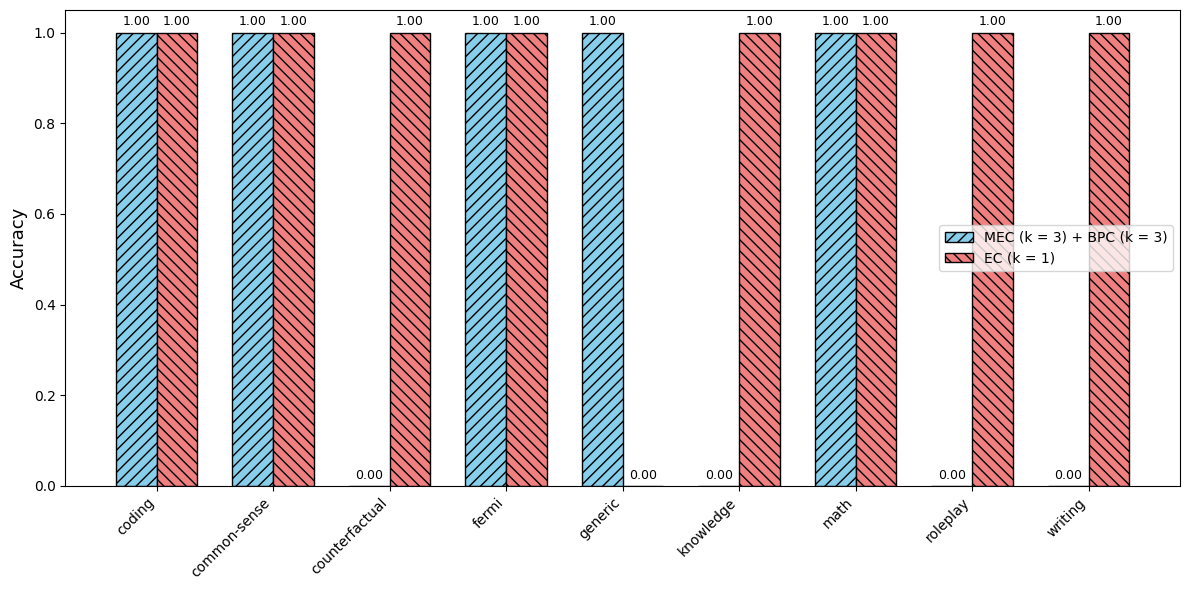

In [45]:
plot_grouped_accuracy_bars(gpt4_best_category_acc, gpt4_worst_category_acc, second_label="EC (k = 1)",
                           first_label='MEC (k = 3) + BPC (k = 3)')

## GPT 3.5
Calculate the accuracy across categories for GPT 3.5

In [46]:
gpt35_best_category_acc = sampled_judgement_result[f"gpt35_{BEST_PARAMETERS_SET}"].groupby('category')[
    'result_hit'].mean()
gpt35_best_category_acc

category
coding            1.0
common-sense      1.0
counterfactual    0.0
fermi             1.0
generic           1.0
knowledge         1.0
math              1.0
roleplay          0.0
writing           1.0
Name: result_hit, dtype: float64

In [47]:
gpt35_worst_category_acc = sampled_judgement_result[f"gpt35_{WORST_PARAMETERS_SET}"].groupby('category')[
    'result_hit'].mean()
gpt35_worst_category_acc

category
coding            1.0
common-sense      0.0
counterfactual    0.0
fermi             1.0
generic           1.0
knowledge         0.0
math              1.0
roleplay          0.0
writing           1.0
Name: result_hit, dtype: float64

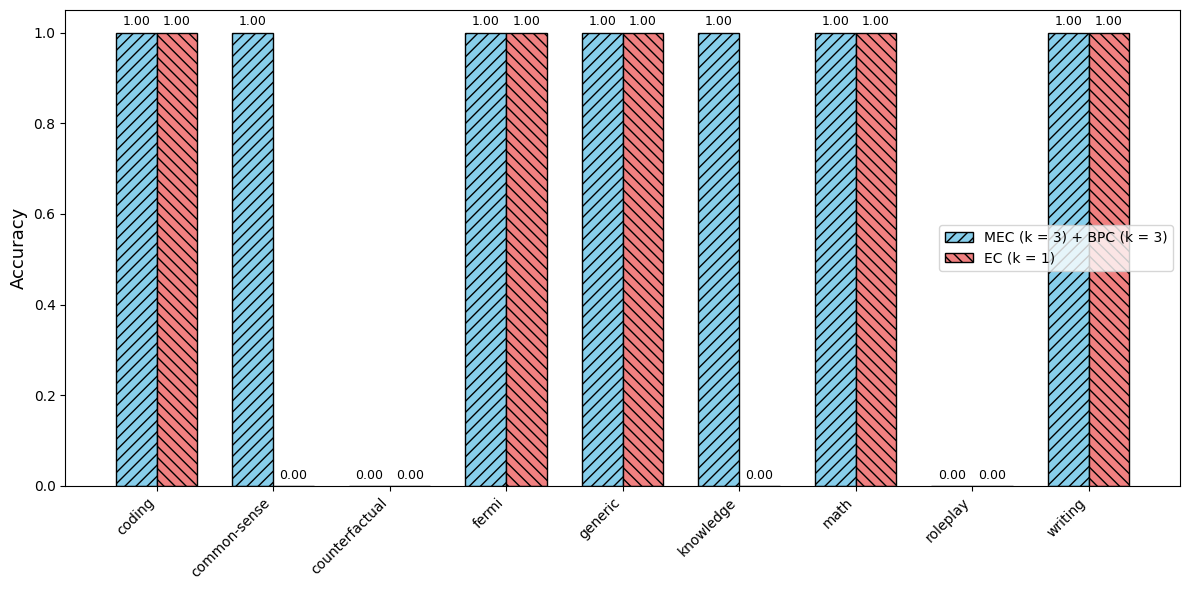

In [48]:
plot_grouped_accuracy_bars(gpt35_best_category_acc, gpt35_worst_category_acc, second_label="EC (k = 1)",
                           first_label='MEC (k = 3) + BPC (k = 3)')

# CascadeEval extraction with GPT-3.5

In [49]:
vicuna_vanilla_questions = pd.read_json('./vicuna/vanilla-vicuna.json')
vicuna_vanilla_questions['ground_truth'] = vicuna_vanilla_questions['question_id'].apply(lambda x: text_lines[x - 1])
vicuna_vanilla_questions = vicuna_vanilla_questions.set_index('question_id')

vicuna_vanilla_questions

,text_vicuna,text_gpt,question_text,category,ground_truth
question_id,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,VICUNA13B
11,Using a single-use plastic bottle versus a reu...,Using a single-use plastic bottle has negative...,What are some potential implications of using ...,knowledge,TIE
28,"As a language model AI, I don't have personal ...","I'm sorry, but as an AI language model, I am n...",You are a mountain climber reaching the summit...,roleplay,CHATGPT
34,It can be difficult to determine if a person i...,There are several ways to determine if a perso...,How can you determine if a person is genuinely...,common-sense,TIE
43,It is difficult to give an exact number of how...,"According to research, it is estimated that th...",How many lightning strikes occur on Earth each...,fermi,CHATGPT
53,"The Black Death, also known as the Plague, was...",If the Black Death had not occurred in the 14t...,What if the Black Death had not occurred in th...,counterfactual,TIE
64,Here is an example of a program in Python that...,Certainly! Here's an example Python program us...,Write a program to find the nth Fibonacci numb...,coding,CHATGPT
70,The length of the line segment is the distance...,To find the length of a line segment with two ...,"If the endpoints of a line segment are (2, -2)...",math,CHATGPT
80,"The concert was a true spectacle of sound, fea...",I'm happy to assist you in writing a symphony ...,"Write a symphony concert review, discussing th...",writing,CHATGPT


In [50]:
cascaded_eval_result_list = []

for i in range(1, 47):
    with open(f'./cascaded-eval-results/vicuna/{i}-auto-j-vicuna-final.json', "r") as f:
        auto_j_results = json.loads(f.read().strip())

    with open(f'./relia_scores/auto-j/vicuna/{i}-relia.json', "r") as f:
        auto_j_top_indices = get_top_half_indices(json.loads(f.read().strip())['Entropy'])

    with open(f'./cascaded-eval-results/vicuna/{i}-judgelm-vicuna-final.json', "r") as f:
        judgelm_results = json.loads(f.read().strip())

    with open(f'./relia_scores/judgelm/vicuna/{i}-relia.json', "r") as f:
        judgelm_top_indices = get_top_half_indices(json.loads(f.read().strip())['Entropy'])

    auto_j = vicuna_vanilla_questions.copy()
    auto_j['score'] = auto_j_results
    auto_j['is_state_of_art'] = [idx not in auto_j_top_indices for idx in range(len(auto_j_results))]

    judgelm = vicuna_vanilla_questions.copy()
    judgelm['score'] = judgelm_results
    judgelm['is_state_of_art'] = [idx not in judgelm_top_indices for idx in range(len(judgelm_results))]

    current_judgement_result = {
        'auto-j': auto_j,
        'judgelm': judgelm,
    }
    cascaded_eval_result_list.append(current_judgement_result)

cascaded_eval_result_list[0]['auto-j']

,text_vicuna,text_gpt,question_text,category,ground_truth,score,is_state_of_art
question_id,,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,VICUNA13B,"[0, 1]",False
11,Using a single-use plastic bottle versus a reu...,Using a single-use plastic bottle has negative...,What are some potential implications of using ...,knowledge,TIE,"[9.0, 8.0]",True
28,"As a language model AI, I don't have personal ...","I'm sorry, but as an AI language model, I am n...",You are a mountain climber reaching the summit...,roleplay,CHATGPT,"[0, 1]",False
34,It can be difficult to determine if a person i...,There are several ways to determine if a perso...,How can you determine if a person is genuinely...,common-sense,TIE,"[0, 1]",False
43,It is difficult to give an exact number of how...,"According to research, it is estimated that th...",How many lightning strikes occur on Earth each...,fermi,CHATGPT,"[1, 0]",False
53,"The Black Death, also known as the Plague, was...",If the Black Death had not occurred in the 14t...,What if the Black Death had not occurred in th...,counterfactual,TIE,"[8.0, 7.0]",True
64,Here is an example of a program in Python that...,Certainly! Here's an example Python program us...,Write a program to find the nth Fibonacci numb...,coding,CHATGPT,"[9.0, 5.0]",True
70,The length of the line segment is the distance...,To find the length of a line segment with two ...,"If the endpoints of a line segment are (2, -2)...",math,CHATGPT,"[9.0, 6.0]",True
80,"The concert was a true spectacle of sound, fea...",I'm happy to assist you in writing a symphony ...,"Write a symphony concert review, discussing th...",writing,CHATGPT,"[9.0, 8.0]",True


In [51]:
for key in cascaded_eval_result_list[0].keys():
    for idx, res in enumerate(cascaded_eval_result_list):
        original_reviews = pd.read_json(
            f"./sampled_review/{idx + 1}/review_gpt35_vicuna_gpt-3.5-turbo_mec1_bpc0.jsonl",
            lines=True
        ).set_index("question_id")

        df = res[key]

        df['input_tokens'] = df.apply(lambda row: compute_input_tokens(row, original_reviews, 'gpt-3.5-turbo'), axis=1)

        df['output_tokens'] = df.apply(lambda row: compute_output_tokens(row, original_reviews, 'gpt-3.5-turbo'),
                                       axis=1)

cascaded_eval_result_list[0]['auto-j']

,text_vicuna,text_gpt,question_text,category,ground_truth,score,is_state_of_art,input_tokens,output_tokens
question_id,,,,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,VICUNA13B,"[0, 1]",False,0,0
11,Using a single-use plastic bottle versus a reu...,Using a single-use plastic bottle has negative...,What are some potential implications of using ...,knowledge,TIE,"[9.0, 8.0]",True,834,2090
28,"As a language model AI, I don't have personal ...","I'm sorry, but as an AI language model, I am n...",You are a mountain climber reaching the summit...,roleplay,CHATGPT,"[0, 1]",False,0,0
34,It can be difficult to determine if a person i...,There are several ways to determine if a perso...,How can you determine if a person is genuinely...,common-sense,TIE,"[0, 1]",False,0,0
43,It is difficult to give an exact number of how...,"According to research, it is estimated that th...",How many lightning strikes occur on Earth each...,fermi,CHATGPT,"[1, 0]",False,0,0
53,"The Black Death, also known as the Plague, was...",If the Black Death had not occurred in the 14t...,What if the Black Death had not occurred in th...,counterfactual,TIE,"[8.0, 7.0]",True,809,996
64,Here is an example of a program in Python that...,Certainly! Here's an example Python program us...,Write a program to find the nth Fibonacci numb...,coding,CHATGPT,"[9.0, 5.0]",True,814,1863
70,The length of the line segment is the distance...,To find the length of a line segment with two ...,"If the endpoints of a line segment are (2, -2)...",math,CHATGPT,"[9.0, 6.0]",True,549,1041
80,"The concert was a true spectacle of sound, fea...",I'm happy to assist you in writing a symphony ...,"Write a symphony concert review, discussing th...",writing,CHATGPT,"[9.0, 8.0]",True,900,1277


In [52]:
cascaded_judgement_result = {}

for key in cascaded_eval_result_list[0].keys():
    # Stack DataFrames across experiments
    dfs = [res[key] for res in cascaded_eval_result_list]
    combined_df = pd.concat(dfs).groupby('question_id')

    cascaded_judgement_result[key] = combined_df.apply(aggregate)

cascaded_judgement_result['auto-j']

,text_vicuna,text_gpt,question_text,category,ground_truth,score,is_state_of_art,input_tokens,output_tokens,result
question_id,,,,,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,VICUNA13B,"[0, 1]",False,0,0,VICUNA13B
11,Using a single-use plastic bottle versus a reu...,Using a single-use plastic bottle has negative...,What are some potential implications of using ...,knowledge,TIE,"[9.0, 8.0]",True,38364,59205,CHATGPT
28,"As a language model AI, I don't have personal ...","I'm sorry, but as an AI language model, I am n...",You are a mountain climber reaching the summit...,roleplay,CHATGPT,"[0, 1]",False,0,0,VICUNA13B
34,It can be difficult to determine if a person i...,There are several ways to determine if a perso...,How can you determine if a person is genuinely...,common-sense,TIE,"[0, 1]",False,0,0,VICUNA13B
43,It is difficult to give an exact number of how...,"According to research, it is estimated that th...",How many lightning strikes occur on Earth each...,fermi,CHATGPT,"[1, 0]",False,0,0,CHATGPT
53,"The Black Death, also known as the Plague, was...",If the Black Death had not occurred in the 14t...,What if the Black Death had not occurred in th...,counterfactual,TIE,"[8.0, 7.0]",True,37214,56013,CHATGPT
64,Here is an example of a program in Python that...,Certainly! Here's an example Python program us...,Write a program to find the nth Fibonacci numb...,coding,CHATGPT,"[9.0, 5.0]",True,37444,69014,CHATGPT
70,The length of the line segment is the distance...,To find the length of a line segment with two ...,"If the endpoints of a line segment are (2, -2)...",math,CHATGPT,"[9.0, 6.0]",True,25254,36921,CHATGPT
80,"The concert was a true spectacle of sound, fea...",I'm happy to assist you in writing a symphony ...,"Write a symphony concert review, discussing th...",writing,CHATGPT,"[9.0, 8.0]",True,41400,49224,CHATGPT


In [53]:
for df in cascaded_judgement_result.values():
    df['result_hit'] = df['ground_truth'] == df['result']

cascaded_judgement_result['auto-j']

,text_vicuna,text_gpt,question_text,category,ground_truth,score,is_state_of_art,input_tokens,output_tokens,result,result_hit
question_id,,,,,,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,VICUNA13B,"[0, 1]",False,0,0,VICUNA13B,True
11,Using a single-use plastic bottle versus a reu...,Using a single-use plastic bottle has negative...,What are some potential implications of using ...,knowledge,TIE,"[9.0, 8.0]",True,38364,59205,CHATGPT,False
28,"As a language model AI, I don't have personal ...","I'm sorry, but as an AI language model, I am n...",You are a mountain climber reaching the summit...,roleplay,CHATGPT,"[0, 1]",False,0,0,VICUNA13B,False
34,It can be difficult to determine if a person i...,There are several ways to determine if a perso...,How can you determine if a person is genuinely...,common-sense,TIE,"[0, 1]",False,0,0,VICUNA13B,False
43,It is difficult to give an exact number of how...,"According to research, it is estimated that th...",How many lightning strikes occur on Earth each...,fermi,CHATGPT,"[1, 0]",False,0,0,CHATGPT,True
53,"The Black Death, also known as the Plague, was...",If the Black Death had not occurred in the 14t...,What if the Black Death had not occurred in th...,counterfactual,TIE,"[8.0, 7.0]",True,37214,56013,CHATGPT,False
64,Here is an example of a program in Python that...,Certainly! Here's an example Python program us...,Write a program to find the nth Fibonacci numb...,coding,CHATGPT,"[9.0, 5.0]",True,37444,69014,CHATGPT,True
70,The length of the line segment is the distance...,To find the length of a line segment with two ...,"If the endpoints of a line segment are (2, -2)...",math,CHATGPT,"[9.0, 6.0]",True,25254,36921,CHATGPT,True
80,"The concert was a true spectacle of sound, fea...",I'm happy to assist you in writing a symphony ...,"Write a symphony concert review, discussing th...",writing,CHATGPT,"[9.0, 8.0]",True,41400,49224,CHATGPT,True


In [54]:
cascaded_accuracy_map = {}

for idx, df in cascaded_judgement_result.items():
    cascaded_accuracy_map[idx] = df["result_hit"].mean() * 100

cascaded_accuracy_map

{'auto-j': np.float64(55.55555555555556),
 'judgelm': np.float64(55.55555555555556)}

In [55]:
cascaded_kappa_map = {}

for idx, df in cascaded_judgement_result.items():
    cascaded_kappa_map[idx] = cohen_kappa_score(df["ground_truth"], df["result"])

cascaded_kappa_map

{'auto-j': np.float64(0.2500000000000001),
 'judgelm': np.float64(0.18181818181818188)}

In [56]:
cascaded_f1_map = {}

for idx, df in cascaded_judgement_result.items():
    cascaded_f1_map[idx] = f1_score(df["ground_truth"], df["result"], average='macro')

cascaded_f1_map

{'auto-j': 0.4090909090909091, 'judgelm': 0.3757575757575758}

In [57]:
cascaded_input_tokens = {}
cascaded_output_tokens = {}

for idx, df in cascaded_judgement_result.items():
    cascaded_input_tokens[idx] = df['input_tokens'].sum()
    cascaded_output_tokens[idx] = df['output_tokens'].sum()

cascaded_input_tokens

{'auto-j': np.int64(179676), 'judgelm': np.int64(181286)}

In [58]:
CASCADED_DESCRIPTION_MAP = {
    'auto-j': {
        'judge': 'Auto-J (CascadedEval with GPT-3.5)',
        'description': 'CascadedEval + EC (k = 1) + GPT-3.5'
    },
    'judgelm': {
        'judge': 'JudgeLM (CascadedEval with GPT-3.5)',
        'description': 'CascadedEval + EC (k = 1) + GPT-3.5'
    },
}

In [59]:
cascaded_final_table = pd.DataFrame({
    "judge": [v["judge"] for v in CASCADED_DESCRIPTION_MAP.values()],
    "description": [v["description"] for v in CASCADED_DESCRIPTION_MAP.values()],
    "accuracy": cascaded_accuracy_map.values(),
    "kappa": cascaded_kappa_map.values(),
    "F1": cascaded_f1_map.values(),
    "input_tokens": cascaded_input_tokens.values(),
    "output_tokens": cascaded_output_tokens.values()
}, index=cascaded_accuracy_map.keys())

cascaded_final_table = pd.concat([cascaded_final_table, final_table], ignore_index=True)
cascaded_final_table

,judge,description,accuracy,kappa,F1,input_tokens,output_tokens
0,Auto-J (CascadedEval with GPT-3.5),CascadedEval + EC (k = 1) + GPT-3.5,55.555556,0.250000,0.409091,179676,270377
1,JudgeLM (CascadedEval with GPT-3.5),CascadedEval + EC (k = 1) + GPT-3.5,55.555556,0.181818,0.375758,181286,274770
2,GPT-3.5,EC (k = 1),55.555556,0.250000,0.409091,318366,488478
3,GPT-4,EC (k = 1),88.888889,0.727273,0.861538,301346,350846
4,GPT-3.5 + MEC + BPC,MEC (k = 3) + BPC (k = 3),77.777778,0.600000,0.546296,1795656,3058575
5,GPT-4 + MEC + BPC,MEC (k = 3) + BPC (k = 3),55.555556,0.265306,0.412698,1932552,2117831


# MEC with CascadedEval extraction with GPT-3.5

In [60]:
vicuna_mec_questions = pd.read_json('./vicuna/mec-bpc-vicuna.json')
vicuna_mec_questions['ground_truth'] = vicuna_mec_questions['question_id'].apply(lambda x: text_lines[x - 1])
vicuna_mec_questions = vicuna_mec_questions.set_index('question_id')

vicuna_mec_questions

,text_vicuna,text_gpt,question_text,category,is_reversed,ground_truth
question_id,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B


In [61]:
mec_cascaded_eval_result_list = []

for i in range(1, 47):
    with open(f'./cascaded-eval-results/vicuna-mec/{i}-auto-j-vicuna-mec-final.json', "r") as f:
        auto_j_results = json.loads(f.read().strip())

    with open(f'./relia_scores/auto-j/vicuna-mec/{i}-relia.json', "r") as f:
        auto_j_top_indices = get_top_half_indices(json.loads(f.read().strip())['Entropy'])

    with open(f'./cascaded-eval-results/vicuna-mec/{i}-judgelm-vicuna-mec-final.json', "r") as f:
        judgelm_results = json.loads(f.read().strip())

    with open(f'./relia_scores/judgelm/vicuna-mec/{i}-relia.json', "r") as f:
        judgelm_top_indices = get_top_half_indices(json.loads(f.read().strip())['Entropy'])

    auto_j = vicuna_mec_questions.copy()
    auto_j['score'] = auto_j_results
    auto_j['is_state_of_art'] = [idx not in auto_j_top_indices for idx in range(len(auto_j_results))]

    judgelm = vicuna_mec_questions.copy()
    judgelm['score'] = judgelm_results
    judgelm['is_state_of_art'] = [idx not in judgelm_top_indices for idx in range(len(judgelm_results))]

    current_judgement_result = {
        'auto-j': auto_j,
        'judgelm': judgelm,
    }

    mec_cascaded_eval_result_list.append(current_judgement_result)

mec_cascaded_eval_result_list[0]['auto-j']

,text_vicuna,text_gpt,question_text,category,is_reversed,ground_truth,score,is_state_of_art
question_id,,,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]",False
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]",False
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]",False
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[1, 0]",False
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[1, 0]",False
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[1, 0]",False
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B,"[0, 1]",False
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B,"[0, 1]",False
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B,"[0, 1]",False


In [62]:
for key in mec_cascaded_eval_result_list[0].keys():
    for idx, res in enumerate(mec_cascaded_eval_result_list):
        original_reviews = pd.read_json(
            f"./sampled_review/{idx + 1}/review_gpt35_vicuna_gpt-3.5-turbo_mec3_bpc1.jsonl",
            lines=True
        ).set_index("question_id")

        df = res[key]

        df['input_tokens'] = df.apply(lambda row: compute_input_tokens(row, original_reviews, 'gpt-3.5-turbo'), axis=1)

        df['output_tokens'] = df.apply(lambda row: compute_output_tokens(row, original_reviews, 'gpt-3.5-turbo'),
                                       axis=1)

mec_cascaded_eval_result_list[0]['auto-j']

,text_vicuna,text_gpt,question_text,category,is_reversed,ground_truth,score,is_state_of_art,input_tokens,output_tokens
question_id,,,,,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]",False,0,0
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]",False,0,0
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]",False,0,0
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[1, 0]",False,0,0
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[1, 0]",False,0,0
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[1, 0]",False,0,0
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B,"[0, 1]",False,0,0
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B,"[0, 1]",False,0,0
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B,"[0, 1]",False,0,0


In [63]:
for current_eval_result in mec_cascaded_eval_result_list:
    for key, value in current_eval_result.items():
        scores = value['score']  # Series of [first_score, second_score]
        is_reversed = value['is_reversed']  # List or Series of booleans

        results = []
        for i, score_pair in enumerate(scores):
            first_score, second_score = score_pair
            diff = second_score - first_score if is_reversed.iloc[i] else first_score - second_score
            result = 'CHATGPT' if diff > 0 else 'VICUNA13B' if diff < 0 else 'TIE'
            results.append(result)

        value['result'] = results

mec_cascaded_eval_result_list[0]['auto-j']

,text_vicuna,text_gpt,question_text,category,is_reversed,ground_truth,score,is_state_of_art,input_tokens,output_tokens,result
question_id,,,,,,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]",False,0,0,VICUNA13B
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]",False,0,0,VICUNA13B
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]",False,0,0,VICUNA13B
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[1, 0]",False,0,0,VICUNA13B
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[1, 0]",False,0,0,VICUNA13B
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[1, 0]",False,0,0,VICUNA13B
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B,"[0, 1]",False,0,0,VICUNA13B
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B,"[0, 1]",False,0,0,VICUNA13B
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B,"[0, 1]",False,0,0,VICUNA13B


In [64]:
for current_eval_result in mec_cascaded_eval_result_list:
    for key, value in current_eval_result.items():
        current_eval_result[key] = value.groupby('question_id').agg({
            'result': lambda x: x.value_counts().idxmax(),
            'input_tokens': 'sum',
            'output_tokens': 'sum'
        })

mec_cascaded_eval_result_list[0]['auto-j']

,result,input_tokens,output_tokens
question_id,,,
5,VICUNA13B,0,0
18,VICUNA13B,5124,8262
26,CHATGPT,23112,55104
40,VICUNA13B,0,0
45,CHATGPT,11646,23286
53,VICUNA13B,0,0
63,VICUNA13B,24912,57114
70,CHATGPT,19764,30552
76,CHATGPT,28440,42235


In [65]:
mec_grouped_questions = vicuna_mec_questions.groupby('question_id', group_keys=False).apply(
    lambda x: x.sample(n=1, random_state=42))
mec_grouped_questions

,text_vicuna,text_gpt,question_text,category,is_reversed,ground_truth
question_id,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B
26,"In the final seconds of the championship game,...",It's the final moments of the championship gam...,"As a sports commentator, describe the winning ...",roleplay,False,CHATGPT
40,In a world where automation is becoming increa...,It's important to strike a balance between job...,In a world where automation is becoming increa...,common-sense,False,VICUNA13B
45,"I'm sorry, but I cannot provide a specific ans...","According to the latest statistics, more than ...",How many text messages are sent globally in a ...,fermi,False,CHATGPT
53,"The Black Death, also known as the Plague, was...",If the Black Death had not occurred in the 14t...,What if the Black Death had not occurred in th...,counterfactual,False,TIE
63,Here is a regular expression that can be used ...,Here's a regular expression pattern in Python ...,Implement a regular expression in Python to va...,coding,False,VICUNA13B
70,The length of the line segment is the distance...,To find the length of a line segment with two ...,"If the endpoints of a line segment are (2, -2)...",math,False,CHATGPT
76,Hello and welcome to our YouTube video on the ...,Title: The Evolution and Cultural Significance...,Write a script for a YouTube video exploring t...,writing,False,CHATGPT


In [66]:
for current_eval_result in mec_cascaded_eval_result_list:
    for key, value in current_eval_result.items():
        current_eval_result[key] = pd.merge(current_eval_result[key], mec_grouped_questions, left_index=True,
                                            right_index=True)

mec_cascaded_eval_result_list[0]['auto-j']

,result,input_tokens,output_tokens,text_vicuna,text_gpt,question_text,category,is_reversed,ground_truth
question_id,,,,,,,,,
5,VICUNA13B,0,0,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B
18,VICUNA13B,5124,8262,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B
26,CHATGPT,23112,55104,"In the final seconds of the championship game,...",It's the final moments of the championship gam...,"As a sports commentator, describe the winning ...",roleplay,False,CHATGPT
40,VICUNA13B,0,0,In a world where automation is becoming increa...,It's important to strike a balance between job...,In a world where automation is becoming increa...,common-sense,False,VICUNA13B
45,CHATGPT,11646,23286,"I'm sorry, but I cannot provide a specific ans...","According to the latest statistics, more than ...",How many text messages are sent globally in a ...,fermi,False,CHATGPT
53,VICUNA13B,0,0,"The Black Death, also known as the Plague, was...",If the Black Death had not occurred in the 14t...,What if the Black Death had not occurred in th...,counterfactual,False,TIE
63,VICUNA13B,24912,57114,Here is a regular expression that can be used ...,Here's a regular expression pattern in Python ...,Implement a regular expression in Python to va...,coding,False,VICUNA13B
70,CHATGPT,19764,30552,The length of the line segment is the distance...,To find the length of a line segment with two ...,"If the endpoints of a line segment are (2, -2)...",math,False,CHATGPT
76,CHATGPT,28440,42235,Hello and welcome to our YouTube video on the ...,Title: The Evolution and Cultural Significance...,Write a script for a YouTube video exploring t...,writing,False,CHATGPT


In [67]:
final_mec_results = {}

for key in mec_cascaded_eval_result_list[0].keys():
    current_results = mec_cascaded_eval_result_list[0][key].drop(['result'], axis=1)
    results = [item[key]['result'] for item in mec_cascaded_eval_result_list]

    question_value_map = defaultdict(list)

    for result in results:
        for qid, val in result.items():
            question_value_map[qid].append(val)

    most_frequent_per_question = {
        qid: Counter(values).most_common(1)[0][0]
        for qid, values in question_value_map.items()
    }

    current_results['result'] = most_frequent_per_question

    final_mec_results[key] = current_results

final_mec_results['auto-j']

,input_tokens,output_tokens,text_vicuna,text_gpt,question_text,category,is_reversed,ground_truth,result
question_id,,,,,,,,,
5,0,0,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,VICUNA13B
18,5124,8262,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B,VICUNA13B
26,23112,55104,"In the final seconds of the championship game,...",It's the final moments of the championship gam...,"As a sports commentator, describe the winning ...",roleplay,False,CHATGPT,CHATGPT
40,0,0,In a world where automation is becoming increa...,It's important to strike a balance between job...,In a world where automation is becoming increa...,common-sense,False,VICUNA13B,VICUNA13B
45,11646,23286,"I'm sorry, but I cannot provide a specific ans...","According to the latest statistics, more than ...",How many text messages are sent globally in a ...,fermi,False,CHATGPT,CHATGPT
53,0,0,"The Black Death, also known as the Plague, was...",If the Black Death had not occurred in the 14t...,What if the Black Death had not occurred in th...,counterfactual,False,TIE,VICUNA13B
63,24912,57114,Here is a regular expression that can be used ...,Here's a regular expression pattern in Python ...,Implement a regular expression in Python to va...,coding,False,VICUNA13B,VICUNA13B
70,19764,30552,The length of the line segment is the distance...,To find the length of a line segment with two ...,"If the endpoints of a line segment are (2, -2)...",math,False,CHATGPT,CHATGPT
76,28440,42235,Hello and welcome to our YouTube video on the ...,Title: The Evolution and Cultural Significance...,Write a script for a YouTube video exploring t...,writing,False,CHATGPT,CHATGPT


In [68]:
for df in final_mec_results.values():
    df['result_hit'] = df['ground_truth'] == df['result']

final_mec_results['auto-j']

,input_tokens,output_tokens,text_vicuna,text_gpt,question_text,category,is_reversed,ground_truth,result,result_hit
question_id,,,,,,,,,,
5,0,0,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,VICUNA13B,True
18,5124,8262,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B,VICUNA13B,True
26,23112,55104,"In the final seconds of the championship game,...",It's the final moments of the championship gam...,"As a sports commentator, describe the winning ...",roleplay,False,CHATGPT,CHATGPT,True
40,0,0,In a world where automation is becoming increa...,It's important to strike a balance between job...,In a world where automation is becoming increa...,common-sense,False,VICUNA13B,VICUNA13B,True
45,11646,23286,"I'm sorry, but I cannot provide a specific ans...","According to the latest statistics, more than ...",How many text messages are sent globally in a ...,fermi,False,CHATGPT,CHATGPT,True
53,0,0,"The Black Death, also known as the Plague, was...",If the Black Death had not occurred in the 14t...,What if the Black Death had not occurred in th...,counterfactual,False,TIE,VICUNA13B,False
63,24912,57114,Here is a regular expression that can be used ...,Here's a regular expression pattern in Python ...,Implement a regular expression in Python to va...,coding,False,VICUNA13B,VICUNA13B,True
70,19764,30552,The length of the line segment is the distance...,To find the length of a line segment with two ...,"If the endpoints of a line segment are (2, -2)...",math,False,CHATGPT,CHATGPT,True
76,28440,42235,Hello and welcome to our YouTube video on the ...,Title: The Evolution and Cultural Significance...,Write a script for a YouTube video exploring t...,writing,False,CHATGPT,CHATGPT,True


In [69]:
mec_cascaded_accuracy_map = {}

for idx, df in final_mec_results.items():
    mec_cascaded_accuracy_map[idx] = df["result_hit"].mean() * 100

mec_cascaded_accuracy_map

{'auto-j': np.float64(88.88888888888889),
 'judgelm': np.float64(55.55555555555556)}

In [70]:
mec_cascaded_kappa_map = {}

for idx, df in final_mec_results.items():
    mec_cascaded_kappa_map[idx] = cohen_kappa_score(df["ground_truth"], df["result"])

mec_cascaded_kappa_map

{'auto-j': np.float64(0.8), 'judgelm': np.float64(0.2500000000000001)}

In [71]:
mec_cascaded_f1_map = {}

for idx, df in final_mec_results.items():
    mec_cascaded_f1_map[idx] = f1_score(df["ground_truth"], df["result"], average='macro')

mec_cascaded_f1_map

{'auto-j': 0.6296296296296297, 'judgelm': 0.41269841269841273}

In [72]:
mec_cascaded_input_tokens = {}
mec_cascaded_output_tokens = {}

for idx, df in final_mec_results.items():
    mec_cascaded_input_tokens[idx] = df['input_tokens'].sum()
    mec_cascaded_output_tokens[idx] = df['output_tokens'].sum()

mec_cascaded_input_tokens

{'auto-j': np.int64(112998), 'judgelm': np.int64(110490)}

In [73]:
MEC_CASCADED_DESCRIPTION_MAP = {
    'auto-j': {
        'judge': 'Auto-J (CascadedEval with GPT-3.5) + MEC + BPC',
        'description': 'CascadedEval + MEC (k = 3) + BPC (k = 3) + GPT-3.5'
    },
    'judgelm': {
        'judge': 'JudgeLM (CascadedEval with GPT-3.5) + MEC + BPC',
        'description': 'CascadedEval + MEC (k = 3) + BPC (k = 3) + GPT-3.5'
    },
}

In [74]:
mec_cascaded_final_table = pd.DataFrame({
    "judge": [v["judge"] for v in MEC_CASCADED_DESCRIPTION_MAP.values()],
    "description": [v["description"] for v in MEC_CASCADED_DESCRIPTION_MAP.values()],
    "accuracy": mec_cascaded_accuracy_map.values(),
    "kappa": mec_cascaded_kappa_map.values(),
    "F1": mec_cascaded_f1_map.values(),
    "input_tokens": mec_cascaded_input_tokens.values(),
    "output_tokens": mec_cascaded_output_tokens.values()
}, index=mec_cascaded_accuracy_map.keys())

mec_cascaded_final_table = pd.concat([mec_cascaded_final_table, cascaded_final_table], ignore_index=True)
mec_cascaded_final_table

,judge,description,accuracy,kappa,F1,input_tokens,output_tokens
0,Auto-J (CascadedEval with GPT-3.5) + MEC + BPC,CascadedEval + MEC (k = 3) + BPC (k = 3) + GPT...,88.888889,0.800000,0.629630,112998,216553
1,JudgeLM (CascadedEval with GPT-3.5) + MEC + BPC,CascadedEval + MEC (k = 3) + BPC (k = 3) + GPT...,55.555556,0.250000,0.412698,110490,211865
2,Auto-J (CascadedEval with GPT-3.5),CascadedEval + EC (k = 1) + GPT-3.5,55.555556,0.250000,0.409091,179676,270377
3,JudgeLM (CascadedEval with GPT-3.5),CascadedEval + EC (k = 1) + GPT-3.5,55.555556,0.181818,0.375758,181286,274770
4,GPT-3.5,EC (k = 1),55.555556,0.250000,0.409091,318366,488478
5,GPT-4,EC (k = 1),88.888889,0.727273,0.861538,301346,350846
6,GPT-3.5 + MEC + BPC,MEC (k = 3) + BPC (k = 3),77.777778,0.600000,0.546296,1795656,3058575
7,GPT-4 + MEC + BPC,MEC (k = 3) + BPC (k = 3),55.555556,0.265306,0.412698,1932552,2117831


# CascadeEval extraction with GPT-4

In [75]:
vicuna_vanilla_questions_gpt4 = pd.read_json('./vicuna/vanilla-vicuna-gpt4.json')
vicuna_vanilla_questions_gpt4['ground_truth'] = vicuna_vanilla_questions_gpt4['question_id'].apply(
    lambda x: text_lines[x - 1])
vicuna_vanilla_questions_gpt4 = vicuna_vanilla_questions_gpt4.set_index('question_id')

vicuna_vanilla_questions_gpt4

,text_vicuna,text_gpt,question_text,category,ground_truth
question_id,,,,,
7,Developing your critical thinking skills can h...,"Sure, here are a few practical tips to develop...",How can I develop my critical thinking skills?,generic,CHATGPT
17,"Vaccinations work by introducing a small, harm...",Vaccinations work by introducing a weakened or...,How do vaccinations work to protect individual...,knowledge,VICUNA13B
27,"Ladies and gentlemen, my name is [Chef's Name]...","Welcome, esteemed judges. I'm excited to prese...",Pretend to be a world-famous chef. How would y...,roleplay,CHATGPT
38,Observing the behavior of other people in a so...,Observing the behavior of other people in a so...,How can observing the behavior of other people...,common-sense,CHATGPT
45,"I'm sorry, but I cannot provide a specific ans...","According to the latest statistics, more than ...",How many text messages are sent globally in a ...,fermi,CHATGPT
57,The Suez Canal is a man-made waterway that con...,"If the Suez Canal had never been constructed, ...",What if the Suez Canal had never been construc...,counterfactual,VICUNA13B
66,Here is an implementation of a queue using two...,Here's an example implementation of a queue us...,Implement a queue data structure using two sta...,coding,CHATGPT
69,We can solve this equation using the following...,3x + 10 = 5(x - 2)\n\n3x + 10 = 5x - 10 (use ...,Solve for x in the equation 3x + 10 = 5(x - 2).,math,CHATGPT
76,Hello and welcome to our YouTube video on the ...,Title: The Evolution and Cultural Significance...,Write a script for a YouTube video exploring t...,writing,CHATGPT


In [76]:
cascaded_eval_result_list_gpt4 = []

for i in range(1, 47):
    with open(f'./cascaded-eval-results/vicuna-gpt4/{i}-auto-j-vicuna-gpt4-final.json', "r") as f:
        auto_j_results = json.loads(f.read().strip())

    with open(f'./relia_scores/auto-j/vicuna-gpt4/{i}-relia.json', "r") as f:
        auto_j_top_indices = get_top_half_indices(json.loads(f.read().strip())['Entropy'])

    with open(f'./cascaded-eval-results/vicuna-gpt4/{i}-judgelm-vicuna-gpt4-final.json', "r") as f:
        judgelm_results = json.loads(f.read().strip())

    with open(f'./relia_scores/judgelm/vicuna-gpt4/{i}-relia.json', "r") as f:
        judgelm_top_indices = get_top_half_indices(json.loads(f.read().strip())['Entropy'])

    auto_j = vicuna_vanilla_questions_gpt4.copy()
    auto_j['score'] = auto_j_results
    auto_j['is_state_of_art'] = [idx not in auto_j_top_indices for idx in range(len(auto_j_results))]

    judgelm = vicuna_vanilla_questions_gpt4.copy()
    judgelm['score'] = judgelm_results
    judgelm['is_state_of_art'] = [idx not in judgelm_top_indices for idx in range(len(judgelm_results))]

    current_judgement_result = {
        'auto-j': auto_j,
        'judgelm': judgelm,
    }

    cascaded_eval_result_list_gpt4.append(current_judgement_result)

cascaded_eval_result_list_gpt4[0]['auto-j']

,text_vicuna,text_gpt,question_text,category,ground_truth,score,is_state_of_art
question_id,,,,,,,
7,Developing your critical thinking skills can h...,"Sure, here are a few practical tips to develop...",How can I develop my critical thinking skills?,generic,CHATGPT,"[0, 1]",False
17,"Vaccinations work by introducing a small, harm...",Vaccinations work by introducing a weakened or...,How do vaccinations work to protect individual...,knowledge,VICUNA13B,"[0, 1]",False
27,"Ladies and gentlemen, my name is [Chef's Name]...","Welcome, esteemed judges. I'm excited to prese...",Pretend to be a world-famous chef. How would y...,roleplay,CHATGPT,"[9.0, 8.0]",True
38,Observing the behavior of other people in a so...,Observing the behavior of other people in a so...,How can observing the behavior of other people...,common-sense,CHATGPT,"[10.0, 9.0]",True
45,"I'm sorry, but I cannot provide a specific ans...","According to the latest statistics, more than ...",How many text messages are sent globally in a ...,fermi,CHATGPT,"[1, 0]",False
57,The Suez Canal is a man-made waterway that con...,"If the Suez Canal had never been constructed, ...",What if the Suez Canal had never been construc...,counterfactual,VICUNA13B,"[0, 1]",False
66,Here is an implementation of a queue using two...,Here's an example implementation of a queue us...,Implement a queue data structure using two sta...,coding,CHATGPT,"[10.0, 2.0]",True
69,We can solve this equation using the following...,3x + 10 = 5(x - 2)\n\n3x + 10 = 5x - 10 (use ...,Solve for x in the equation 3x + 10 = 5(x - 2).,math,CHATGPT,"[10.0, 2.0]",True
76,Hello and welcome to our YouTube video on the ...,Title: The Evolution and Cultural Significance...,Write a script for a YouTube video exploring t...,writing,CHATGPT,"[9.0, 8.5]",True


In [77]:
for key in cascaded_eval_result_list_gpt4[0].keys():
    for idx, res in enumerate(cascaded_eval_result_list_gpt4):
        original_reviews = pd.read_json(
            f"./sampled_review/{idx + 1}/review_gpt35_vicuna_gpt-4_mec1_bpc0.jsonl",
            lines=True
        ).set_index("question_id")

        df = res[key]

        df['input_tokens'] = df.apply(lambda row: compute_input_tokens(row, original_reviews, 'gpt-4'), axis=1)

        df['output_tokens'] = df.apply(lambda row: compute_output_tokens(row, original_reviews, 'gpt-4'), axis=1)

cascaded_eval_result_list_gpt4[0]['auto-j']

,text_vicuna,text_gpt,question_text,category,ground_truth,score,is_state_of_art,input_tokens,output_tokens
question_id,,,,,,,,,
7,Developing your critical thinking skills can h...,"Sure, here are a few practical tips to develop...",How can I develop my critical thinking skills?,generic,CHATGPT,"[0, 1]",False,0,0
17,"Vaccinations work by introducing a small, harm...",Vaccinations work by introducing a weakened or...,How do vaccinations work to protect individual...,knowledge,VICUNA13B,"[0, 1]",False,0,0
27,"Ladies and gentlemen, my name is [Chef's Name]...","Welcome, esteemed judges. I'm excited to prese...",Pretend to be a world-famous chef. How would y...,roleplay,CHATGPT,"[9.0, 8.0]",True,814,755
38,Observing the behavior of other people in a so...,Observing the behavior of other people in a so...,How can observing the behavior of other people...,common-sense,CHATGPT,"[10.0, 9.0]",True,666,661
45,"I'm sorry, but I cannot provide a specific ans...","According to the latest statistics, more than ...",How many text messages are sent globally in a ...,fermi,CHATGPT,"[1, 0]",False,0,0
57,The Suez Canal is a man-made waterway that con...,"If the Suez Canal had never been constructed, ...",What if the Suez Canal had never been construc...,counterfactual,VICUNA13B,"[0, 1]",False,0,0
66,Here is an implementation of a queue using two...,Here's an example implementation of a queue us...,Implement a queue data structure using two sta...,coding,CHATGPT,"[10.0, 2.0]",True,847,840
69,We can solve this equation using the following...,3x + 10 = 5(x - 2)\n\n3x + 10 = 5x - 10 (use ...,Solve for x in the equation 3x + 10 = 5(x - 2).,math,CHATGPT,"[10.0, 2.0]",True,641,687
76,Hello and welcome to our YouTube video on the ...,Title: The Evolution and Cultural Significance...,Write a script for a YouTube video exploring t...,writing,CHATGPT,"[9.0, 8.5]",True,948,1057


In [78]:
cascaded_judgement_result_gpt4 = {}

for key in cascaded_eval_result_list_gpt4[0].keys():
    # Stack DataFrames across experiments
    dfs = [res[key] for res in cascaded_eval_result_list_gpt4]

    combined_df = pd.concat(dfs).groupby('question_id')

    cascaded_judgement_result_gpt4[key] = combined_df.apply(aggregate)

cascaded_judgement_result_gpt4['auto-j']

,text_vicuna,text_gpt,question_text,category,ground_truth,score,is_state_of_art,input_tokens,output_tokens,result
question_id,,,,,,,,,,
7,Developing your critical thinking skills can h...,"Sure, here are a few practical tips to develop...",How can I develop my critical thinking skills?,generic,CHATGPT,"[0, 1]",False,0,0,VICUNA13B
17,"Vaccinations work by introducing a small, harm...",Vaccinations work by introducing a weakened or...,How do vaccinations work to protect individual...,knowledge,VICUNA13B,"[0, 1]",False,0,0,VICUNA13B
27,"Ladies and gentlemen, my name is [Chef's Name]...","Welcome, esteemed judges. I'm excited to prese...",Pretend to be a world-famous chef. How would y...,roleplay,CHATGPT,"[9.0, 8.0]",True,37444,45674,CHATGPT
38,Observing the behavior of other people in a so...,Observing the behavior of other people in a so...,How can observing the behavior of other people...,common-sense,CHATGPT,"[10.0, 9.0]",True,30636,35925,CHATGPT
45,"I'm sorry, but I cannot provide a specific ans...","According to the latest statistics, more than ...",How many text messages are sent globally in a ...,fermi,CHATGPT,"[1, 0]",False,0,0,CHATGPT
57,The Suez Canal is a man-made waterway that con...,"If the Suez Canal had never been constructed, ...",What if the Suez Canal had never been construc...,counterfactual,VICUNA13B,"[0, 1]",False,0,0,VICUNA13B
66,Here is an implementation of a queue using two...,Here's an example implementation of a queue us...,Implement a queue data structure using two sta...,coding,CHATGPT,"[10.0, 2.0]",True,38962,40139,CHATGPT
69,We can solve this equation using the following...,3x + 10 = 5(x - 2)\n\n3x + 10 = 5x - 10 (use ...,Solve for x in the equation 3x + 10 = 5(x - 2).,math,CHATGPT,"[10.0, 2.0]",True,29486,34063,CHATGPT
76,Hello and welcome to our YouTube video on the ...,Title: The Evolution and Cultural Significance...,Write a script for a YouTube video exploring t...,writing,CHATGPT,"[9.0, 8.5]",True,43608,41725,CHATGPT


In [79]:
for df in cascaded_judgement_result_gpt4.values():
    df['result_hit'] = df['ground_truth'] == df['result']

cascaded_judgement_result_gpt4['auto-j']

,text_vicuna,text_gpt,question_text,category,ground_truth,score,is_state_of_art,input_tokens,output_tokens,result,result_hit
question_id,,,,,,,,,,,
7,Developing your critical thinking skills can h...,"Sure, here are a few practical tips to develop...",How can I develop my critical thinking skills?,generic,CHATGPT,"[0, 1]",False,0,0,VICUNA13B,False
17,"Vaccinations work by introducing a small, harm...",Vaccinations work by introducing a weakened or...,How do vaccinations work to protect individual...,knowledge,VICUNA13B,"[0, 1]",False,0,0,VICUNA13B,True
27,"Ladies and gentlemen, my name is [Chef's Name]...","Welcome, esteemed judges. I'm excited to prese...",Pretend to be a world-famous chef. How would y...,roleplay,CHATGPT,"[9.0, 8.0]",True,37444,45674,CHATGPT,True
38,Observing the behavior of other people in a so...,Observing the behavior of other people in a so...,How can observing the behavior of other people...,common-sense,CHATGPT,"[10.0, 9.0]",True,30636,35925,CHATGPT,True
45,"I'm sorry, but I cannot provide a specific ans...","According to the latest statistics, more than ...",How many text messages are sent globally in a ...,fermi,CHATGPT,"[1, 0]",False,0,0,CHATGPT,True
57,The Suez Canal is a man-made waterway that con...,"If the Suez Canal had never been constructed, ...",What if the Suez Canal had never been construc...,counterfactual,VICUNA13B,"[0, 1]",False,0,0,VICUNA13B,True
66,Here is an implementation of a queue using two...,Here's an example implementation of a queue us...,Implement a queue data structure using two sta...,coding,CHATGPT,"[10.0, 2.0]",True,38962,40139,CHATGPT,True
69,We can solve this equation using the following...,3x + 10 = 5(x - 2)\n\n3x + 10 = 5x - 10 (use ...,Solve for x in the equation 3x + 10 = 5(x - 2).,math,CHATGPT,"[10.0, 2.0]",True,29486,34063,CHATGPT,True
76,Hello and welcome to our YouTube video on the ...,Title: The Evolution and Cultural Significance...,Write a script for a YouTube video exploring t...,writing,CHATGPT,"[9.0, 8.5]",True,43608,41725,CHATGPT,True


In [80]:
cascaded_accuracy_map_gpt4 = {}

for idx, df in cascaded_judgement_result_gpt4.items():
    cascaded_accuracy_map_gpt4[idx] = df["result_hit"].mean() * 100

cascaded_accuracy_map_gpt4

{'auto-j': np.float64(88.88888888888889),
 'judgelm': np.float64(77.77777777777779)}

In [81]:
cascaded_kappa_map_gpt4 = {}

for idx, df in cascaded_judgement_result_gpt4.items():
    cascaded_kappa_map_gpt4[idx] = cohen_kappa_score(df["ground_truth"], df["result"])

cascaded_kappa_map_gpt4

{'auto-j': np.float64(0.7272727272727273), 'judgelm': np.float64(0.55)}

In [82]:
cascaded_f1_map_gpt4 = {}

for idx, df in cascaded_judgement_result_gpt4.items():
    cascaded_f1_map_gpt4[idx] = f1_score(df["ground_truth"], df["result"], average='macro')

cascaded_f1_map_gpt4

{'auto-j': 0.8615384615384616, 'judgelm': 0.5444444444444444}

In [83]:
cascaded_input_tokens_gpt4 = {}
cascaded_output_tokens_gpt4 = {}

for idx, df in cascaded_judgement_result_gpt4.items():
    cascaded_input_tokens_gpt4[idx] = df['input_tokens'].sum()
    cascaded_output_tokens_gpt4[idx] = df['output_tokens'].sum()

cascaded_input_tokens_gpt4

{'auto-j': np.int64(180136), 'judgelm': np.int64(156998)}

In [84]:
CASCADED_DESCRIPTION_GPT4_MAP = {
    'auto-j': {
        'judge': 'Auto-J (CascadedEval with GPT-4)',
        'description': 'CascadedEval + EC (k = 1) + GPT-4'
    },
    'judgelm': {
        'judge': 'JudgeLM (CascadedEval with GPT-4)',
        'description': 'CascadedEval + EC (k = 1) + GPT-4'
    },
}

In [85]:
cascaded_gpt4_table = pd.DataFrame({
    "judge": [v["judge"] for v in CASCADED_DESCRIPTION_GPT4_MAP.values()],
    "description": [v["description"] for v in CASCADED_DESCRIPTION_GPT4_MAP.values()],
    "accuracy": cascaded_accuracy_map_gpt4.values(),
    "kappa": cascaded_kappa_map_gpt4.values(),
    "F1": cascaded_f1_map_gpt4.values(),
    "input_tokens": cascaded_input_tokens_gpt4.values(),
    "output_tokens": cascaded_output_tokens_gpt4.values()
}, index=cascaded_accuracy_map_gpt4.keys())

cascaded_gpt4_table = pd.concat([mec_cascaded_final_table, cascaded_gpt4_table], ignore_index=True)
cascaded_gpt4_table

,judge,description,accuracy,kappa,F1,input_tokens,output_tokens
0,Auto-J (CascadedEval with GPT-3.5) + MEC + BPC,CascadedEval + MEC (k = 3) + BPC (k = 3) + GPT...,88.888889,0.800000,0.629630,112998,216553
1,JudgeLM (CascadedEval with GPT-3.5) + MEC + BPC,CascadedEval + MEC (k = 3) + BPC (k = 3) + GPT...,55.555556,0.250000,0.412698,110490,211865
2,Auto-J (CascadedEval with GPT-3.5),CascadedEval + EC (k = 1) + GPT-3.5,55.555556,0.250000,0.409091,179676,270377
3,JudgeLM (CascadedEval with GPT-3.5),CascadedEval + EC (k = 1) + GPT-3.5,55.555556,0.181818,0.375758,181286,274770
4,GPT-3.5,EC (k = 1),55.555556,0.250000,0.409091,318366,488478
5,GPT-4,EC (k = 1),88.888889,0.727273,0.861538,301346,350846
6,GPT-3.5 + MEC + BPC,MEC (k = 3) + BPC (k = 3),77.777778,0.600000,0.546296,1795656,3058575
7,GPT-4 + MEC + BPC,MEC (k = 3) + BPC (k = 3),55.555556,0.265306,0.412698,1932552,2117831
8,Auto-J (CascadedEval with GPT-4),CascadedEval + EC (k = 1) + GPT-4,88.888889,0.727273,0.861538,180136,197526
9,JudgeLM (CascadedEval with GPT-4),CascadedEval + EC (k = 1) + GPT-4,77.777778,0.550000,0.544444,156998,189180


# MEC with CascadedEval extraction with GPT-4

In [86]:
vicuna_mec_questions_gpt4 = pd.read_json('./vicuna/mec-bpc-vicuna-gpt4.json')
vicuna_mec_questions_gpt4['ground_truth'] = vicuna_mec_questions_gpt4['question_id'].apply(lambda x: text_lines[x - 1])
vicuna_mec_questions_gpt4 = vicuna_mec_questions_gpt4.set_index('question_id')

vicuna_mec_questions_gpt4

,text_vicuna,text_gpt,question_text,category,is_reversed,ground_truth
question_id,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,TIE
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,TIE
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,TIE


In [87]:
mec_cascaded_eval_result_gpt4_list = []

for i in range(1, 47):
    with open(f'./cascaded-eval-results/vicuna-mec-gpt4/{i}-auto-j-vicuna-mec-gpt4-final.json', "r") as f:
        auto_j_results = json.loads(f.read().strip())

    with open(f'./cascaded-eval-results/vicuna-mec-gpt4/{i}-judgelm-vicuna-mec-gpt4-final.json', "r") as f:
        judgelm_results = json.loads(f.read().strip())

    with open(f'./relia_scores/auto-j/vicuna-mec-gpt4/{i}-relia.json', "r") as f:
        auto_j_top_indices = get_top_half_indices(json.loads(f.read().strip())['Entropy'])

    with open(f'./relia_scores/judgelm/vicuna-mec-gpt4/{i}-relia.json', "r") as f:
        judgelm_top_indices = get_top_half_indices(json.loads(f.read().strip())['Entropy'])

    auto_j = vicuna_mec_questions_gpt4.copy()
    auto_j['score'] = auto_j_results
    auto_j['is_state_of_art'] = [idx not in auto_j_top_indices for idx in range(len(auto_j_results))]

    judgelm = vicuna_mec_questions_gpt4.copy()
    judgelm['score'] = judgelm_results
    judgelm['is_state_of_art'] = [idx not in judgelm_top_indices for idx in range(len(judgelm_results))]

    current_judgement_result = {
        'auto-j': auto_j,
        'judgelm': judgelm,
    }

    mec_cascaded_eval_result_gpt4_list.append(current_judgement_result)

mec_cascaded_eval_result_gpt4_list[0]['auto-j']

,text_vicuna,text_gpt,question_text,category,is_reversed,ground_truth,score,is_state_of_art
question_id,,,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]",False
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]",False
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]",False
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[1, 0]",False
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[1, 0]",False
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[1, 0]",False
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,TIE,"[0, 1]",False
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,TIE,"[0, 1]",False
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,TIE,"[0, 1]",False


In [88]:
for key in mec_cascaded_eval_result_gpt4_list[0].keys():
    for idx, res in enumerate(mec_cascaded_eval_result_gpt4_list):
        original_reviews = pd.read_json(
            f"./sampled_review/{idx + 1}/review_gpt35_vicuna_gpt-4_mec3_bpc1.jsonl",
            lines=True
        ).set_index("question_id")

        df = res[key]

        df['input_tokens'] = df.apply(lambda row: compute_input_tokens(row, original_reviews, 'gpt-3.5-turbo'), axis=1)

        df['output_tokens'] = df.apply(lambda row: compute_output_tokens(row, original_reviews, 'gpt-3.5-turbo'),
                                       axis=1)

mec_cascaded_eval_result_gpt4_list[0]['auto-j']

,text_vicuna,text_gpt,question_text,category,is_reversed,ground_truth,score,is_state_of_art,input_tokens,output_tokens
question_id,,,,,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]",False,0,0
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]",False,0,0
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]",False,0,0
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[1, 0]",False,0,0
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[1, 0]",False,0,0
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[1, 0]",False,0,0
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,TIE,"[0, 1]",False,0,0
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,TIE,"[0, 1]",False,0,0
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,TIE,"[0, 1]",False,0,0


In [89]:
for current_eval_result in mec_cascaded_eval_result_gpt4_list:
    for key, value in current_eval_result.items():
        scores = value['score']  # Series of [first_score, second_score]
        is_reversed = value['is_reversed']  # List or Series of booleans

        results = []
        for i, score_pair in enumerate(scores):
            first_score, second_score = score_pair
            diff = second_score - first_score if is_reversed.iloc[i] else first_score - second_score
            result = 'CHATGPT' if diff > 0 else 'VICUNA13B' if diff < 0 else 'TIE'
            results.append(result)

        value['result'] = results

mec_cascaded_eval_result_gpt4_list[0]['auto-j']

,text_vicuna,text_gpt,question_text,category,is_reversed,ground_truth,score,is_state_of_art,input_tokens,output_tokens,result
question_id,,,,,,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]",False,0,0,VICUNA13B
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]",False,0,0,VICUNA13B
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]",False,0,0,VICUNA13B
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[1, 0]",False,0,0,VICUNA13B
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[1, 0]",False,0,0,VICUNA13B
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[1, 0]",False,0,0,VICUNA13B
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,TIE,"[0, 1]",False,0,0,VICUNA13B
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,TIE,"[0, 1]",False,0,0,VICUNA13B
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,TIE,"[0, 1]",False,0,0,VICUNA13B


In [90]:
for current_eval_result in mec_cascaded_eval_result_gpt4_list:
    for key, value in current_eval_result.items():
        current_eval_result[key] = value.groupby('question_id').agg({
            'result': lambda x: x.value_counts().idxmax(),
            'input_tokens': 'sum',
            'output_tokens': 'sum'
        })

mec_cascaded_eval_result_gpt4_list[0]['auto-j']

,result,input_tokens,output_tokens
question_id,,,
5,VICUNA13B,0,0
14,VICUNA13B,0,0
29,VICUNA13B,16146,17160
37,VICUNA13B,11178,12387
47,VICUNA13B,0,0
56,CHATGPT,11826,14139
63,CHATGPT,24912,26712
69,CHATGPT,23076,24060
77,TIE,38664,33756


In [91]:
mec_grouped_gpt4_questions = vicuna_mec_questions_gpt4.groupby('question_id', group_keys=False).apply(
    lambda x: x.sample(n=1, random_state=42))
mec_grouped_gpt4_questions

,text_vicuna,text_gpt,question_text,category,is_reversed,ground_truth
question_id,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,TIE
29,"As a space colonist on Mars, my daily life wou...","As a space colonist on Mars, my daily life wou...","As a space colonist on Mars, describe your dai...",roleplay,False,VICUNA13B
37,There are many factors that can influence why ...,There is no one definitive answer to this ques...,Why do some people enjoy the sensation of bein...,common-sense,False,VICUNA13B
47,The number of snowflakes that fall during a ty...,It's difficult to determine the exact number o...,How many snowflakes fall during a typical wint...,fermi,False,CHATGPT
56,If Alan Turing had not cracked the Enigma code...,If Alan Turing had not cracked the Enigma code...,What if Alan Turing had not cracked the Enigma...,counterfactual,False,TIE
63,Here is a regular expression that can be used ...,Here's a regular expression pattern in Python ...,Implement a regular expression in Python to va...,coding,False,VICUNA13B
69,We can solve this equation using the following...,3x + 10 = 5(x - 2)\n\n3x + 10 = 5x - 10 (use ...,Solve for x in the equation 3x + 10 = 5(x - 2).,math,False,CHATGPT
77,"Aloha, fellow travelers! If you're looking for...","Aloha, fellow travelers! I recently had the pl...",Compose an engaging travel blog post about a r...,writing,False,CHATGPT


In [92]:
for current_eval_result in mec_cascaded_eval_result_gpt4_list:
    for key, value in current_eval_result.items():
        current_eval_result[key] = pd.merge(current_eval_result[key], mec_grouped_gpt4_questions, left_index=True,
                                            right_index=True)

mec_cascaded_eval_result_gpt4_list[0]['auto-j']

,result,input_tokens,output_tokens,text_vicuna,text_gpt,question_text,category,is_reversed,ground_truth
question_id,,,,,,,,,
5,VICUNA13B,0,0,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B
14,VICUNA13B,0,0,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,TIE
29,VICUNA13B,16146,17160,"As a space colonist on Mars, my daily life wou...","As a space colonist on Mars, my daily life wou...","As a space colonist on Mars, describe your dai...",roleplay,False,VICUNA13B
37,VICUNA13B,11178,12387,There are many factors that can influence why ...,There is no one definitive answer to this ques...,Why do some people enjoy the sensation of bein...,common-sense,False,VICUNA13B
47,VICUNA13B,0,0,The number of snowflakes that fall during a ty...,It's difficult to determine the exact number o...,How many snowflakes fall during a typical wint...,fermi,False,CHATGPT
56,CHATGPT,11826,14139,If Alan Turing had not cracked the Enigma code...,If Alan Turing had not cracked the Enigma code...,What if Alan Turing had not cracked the Enigma...,counterfactual,False,TIE
63,CHATGPT,24912,26712,Here is a regular expression that can be used ...,Here's a regular expression pattern in Python ...,Implement a regular expression in Python to va...,coding,False,VICUNA13B
69,CHATGPT,23076,24060,We can solve this equation using the following...,3x + 10 = 5(x - 2)\n\n3x + 10 = 5x - 10 (use ...,Solve for x in the equation 3x + 10 = 5(x - 2).,math,False,CHATGPT
77,TIE,38664,33756,"Aloha, fellow travelers! If you're looking for...","Aloha, fellow travelers! I recently had the pl...",Compose an engaging travel blog post about a r...,writing,False,CHATGPT


In [93]:
final_mec_gpt4_results = {}

for key in mec_cascaded_eval_result_gpt4_list[0].keys():
    current_results = mec_cascaded_eval_result_gpt4_list[0][key].drop(['result'], axis=1)
    results = [item[key]['result'] for item in mec_cascaded_eval_result_gpt4_list]

    question_value_map = defaultdict(list)

    for result in results:
        for qid, val in result.items():
            question_value_map[qid].append(val)

    most_frequent_per_question = {
        qid: Counter(values).most_common(1)[0][0]
        for qid, values in question_value_map.items()
    }

    current_results['result'] = most_frequent_per_question

    final_mec_gpt4_results[key] = current_results

final_mec_gpt4_results['auto-j']

,input_tokens,output_tokens,text_vicuna,text_gpt,question_text,category,is_reversed,ground_truth,result
question_id,,,,,,,,,
5,0,0,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,VICUNA13B
14,0,0,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,TIE,VICUNA13B
29,16146,17160,"As a space colonist on Mars, my daily life wou...","As a space colonist on Mars, my daily life wou...","As a space colonist on Mars, describe your dai...",roleplay,False,VICUNA13B,VICUNA13B
37,11178,12387,There are many factors that can influence why ...,There is no one definitive answer to this ques...,Why do some people enjoy the sensation of bein...,common-sense,False,VICUNA13B,VICUNA13B
47,0,0,The number of snowflakes that fall during a ty...,It's difficult to determine the exact number o...,How many snowflakes fall during a typical wint...,fermi,False,CHATGPT,VICUNA13B
56,11826,14139,If Alan Turing had not cracked the Enigma code...,If Alan Turing had not cracked the Enigma code...,What if Alan Turing had not cracked the Enigma...,counterfactual,False,TIE,CHATGPT
63,24912,26712,Here is a regular expression that can be used ...,Here's a regular expression pattern in Python ...,Implement a regular expression in Python to va...,coding,False,VICUNA13B,VICUNA13B
69,23076,24060,We can solve this equation using the following...,3x + 10 = 5(x - 2)\n\n3x + 10 = 5x - 10 (use ...,Solve for x in the equation 3x + 10 = 5(x - 2).,math,False,CHATGPT,CHATGPT
77,38664,33756,"Aloha, fellow travelers! If you're looking for...","Aloha, fellow travelers! I recently had the pl...",Compose an engaging travel blog post about a r...,writing,False,CHATGPT,VICUNA13B


In [94]:
for df in final_mec_gpt4_results.values():
    df['result_hit'] = df['ground_truth'] == df['result']

final_mec_gpt4_results['auto-j']

,input_tokens,output_tokens,text_vicuna,text_gpt,question_text,category,is_reversed,ground_truth,result,result_hit
question_id,,,,,,,,,,
5,0,0,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,VICUNA13B,True
14,0,0,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,TIE,VICUNA13B,False
29,16146,17160,"As a space colonist on Mars, my daily life wou...","As a space colonist on Mars, my daily life wou...","As a space colonist on Mars, describe your dai...",roleplay,False,VICUNA13B,VICUNA13B,True
37,11178,12387,There are many factors that can influence why ...,There is no one definitive answer to this ques...,Why do some people enjoy the sensation of bein...,common-sense,False,VICUNA13B,VICUNA13B,True
47,0,0,The number of snowflakes that fall during a ty...,It's difficult to determine the exact number o...,How many snowflakes fall during a typical wint...,fermi,False,CHATGPT,VICUNA13B,False
56,11826,14139,If Alan Turing had not cracked the Enigma code...,If Alan Turing had not cracked the Enigma code...,What if Alan Turing had not cracked the Enigma...,counterfactual,False,TIE,CHATGPT,False
63,24912,26712,Here is a regular expression that can be used ...,Here's a regular expression pattern in Python ...,Implement a regular expression in Python to va...,coding,False,VICUNA13B,VICUNA13B,True
69,23076,24060,We can solve this equation using the following...,3x + 10 = 5(x - 2)\n\n3x + 10 = 5x - 10 (use ...,Solve for x in the equation 3x + 10 = 5(x - 2).,math,False,CHATGPT,CHATGPT,True
77,38664,33756,"Aloha, fellow travelers! If you're looking for...","Aloha, fellow travelers! I recently had the pl...",Compose an engaging travel blog post about a r...,writing,False,CHATGPT,VICUNA13B,False


In [95]:
mec_cascaded_accuracy_gpt4_map = {}

for idx, df in final_mec_gpt4_results.items():
    mec_cascaded_accuracy_gpt4_map[idx] = df["result_hit"].mean() * 100

mec_cascaded_accuracy_gpt4_map

{'auto-j': np.float64(55.55555555555556),
 'judgelm': np.float64(55.55555555555556)}

In [96]:
mec_cascaded_kappa_gpt4_map = {}

for idx, df in final_mec_gpt4_results.items():
    mec_cascaded_kappa_gpt4_map[idx] = cohen_kappa_score(df["ground_truth"], df["result"])

mec_cascaded_kappa_gpt4_map

{'auto-j': np.float64(0.23404255319148937),
 'judgelm': np.float64(0.26530612244897966)}

In [97]:
mec_cascaded_f1_gpt4_map = {}

for idx, df in final_mec_gpt4_results.items():
    mec_cascaded_f1_gpt4_map[idx] = f1_score(df["ground_truth"], df["result"], average='macro')

mec_cascaded_f1_gpt4_map

{'auto-j': 0.3757575757575758, 'judgelm': 0.41269841269841273}

In [98]:
mec_cascaded_input_tokens_gpt4 = {}
mec_cascaded_output_tokens_gpt4 = {}

for idx, df in final_mec_gpt4_results.items():
    mec_cascaded_input_tokens_gpt4[idx] = df['input_tokens'].sum()
    mec_cascaded_output_tokens_gpt4[idx] = df['output_tokens'].sum()

mec_cascaded_input_tokens_gpt4

{'auto-j': np.int64(125802), 'judgelm': np.int64(119790)}

In [99]:
MEC_CASCADED_DESCRIPTION_GPT4_MAP = {
    'auto-j': {
        'judge': 'Auto-J (CascadedEval with GPT-4) + MEC + BPC',
        'description': 'CascadedEval + MEC (k = 3) + BPC (k = 3) + GPT-4'
    },
    'judgelm': {
        'judge': 'JudgeLM (CascadedEval with GPT-4) + MEC + BPC',
        'description': 'CascadedEval + MEC (k = 3) + BPC (k = 3) + GPT-4'
    },
}

In [100]:
mec_cascaded_gpt_4table = pd.DataFrame({
    "judge": [v["judge"] for v in MEC_CASCADED_DESCRIPTION_GPT4_MAP.values()],
    "description": [v["description"] for v in MEC_CASCADED_DESCRIPTION_GPT4_MAP.values()],
    "accuracy": mec_cascaded_accuracy_gpt4_map.values(),
    "kappa": mec_cascaded_kappa_gpt4_map.values(),
    "F1": mec_cascaded_f1_gpt4_map.values(),
    "input_tokens": mec_cascaded_input_tokens_gpt4.values(),
    "output_tokens": mec_cascaded_output_tokens_gpt4.values()
}, index=mec_cascaded_accuracy_gpt4_map.keys())

mec_cascaded_gpt_4table = pd.concat([mec_cascaded_gpt_4table, cascaded_gpt4_table], ignore_index=True)
mec_cascaded_gpt_4table

,judge,description,accuracy,kappa,F1,input_tokens,output_tokens
0,Auto-J (CascadedEval with GPT-4) + MEC + BPC,CascadedEval + MEC (k = 3) + BPC (k = 3) + GPT-4,55.555556,0.234043,0.375758,125802,128214
1,JudgeLM (CascadedEval with GPT-4) + MEC + BPC,CascadedEval + MEC (k = 3) + BPC (k = 3) + GPT-4,55.555556,0.265306,0.412698,119790,129771
2,Auto-J (CascadedEval with GPT-3.5) + MEC + BPC,CascadedEval + MEC (k = 3) + BPC (k = 3) + GPT...,88.888889,0.800000,0.629630,112998,216553
3,JudgeLM (CascadedEval with GPT-3.5) + MEC + BPC,CascadedEval + MEC (k = 3) + BPC (k = 3) + GPT...,55.555556,0.250000,0.412698,110490,211865
4,Auto-J (CascadedEval with GPT-3.5),CascadedEval + EC (k = 1) + GPT-3.5,55.555556,0.250000,0.409091,179676,270377
5,JudgeLM (CascadedEval with GPT-3.5),CascadedEval + EC (k = 1) + GPT-3.5,55.555556,0.181818,0.375758,181286,274770
6,GPT-3.5,EC (k = 1),55.555556,0.250000,0.409091,318366,488478
7,GPT-4,EC (k = 1),88.888889,0.727273,0.861538,301346,350846
8,GPT-3.5 + MEC + BPC,MEC (k = 3) + BPC (k = 3),77.777778,0.600000,0.546296,1795656,3058575
9,GPT-4 + MEC + BPC,MEC (k = 3) + BPC (k = 3),55.555556,0.265306,0.412698,1932552,2117831


# Final splitting

## GPT-3.5

In [101]:
gpt35_final = mec_cascaded_gpt_4table[mec_cascaded_gpt_4table['judge'].str.contains('GPT-3.5', na=False)]
gpt35_final

,judge,description,accuracy,kappa,F1,input_tokens,output_tokens
2,Auto-J (CascadedEval with GPT-3.5) + MEC + BPC,CascadedEval + MEC (k = 3) + BPC (k = 3) + GPT...,88.888889,0.800000,0.629630,112998,216553
3,JudgeLM (CascadedEval with GPT-3.5) + MEC + BPC,CascadedEval + MEC (k = 3) + BPC (k = 3) + GPT...,55.555556,0.250000,0.412698,110490,211865
4,Auto-J (CascadedEval with GPT-3.5),CascadedEval + EC (k = 1) + GPT-3.5,55.555556,0.250000,0.409091,179676,270377
5,JudgeLM (CascadedEval with GPT-3.5),CascadedEval + EC (k = 1) + GPT-3.5,55.555556,0.181818,0.375758,181286,274770
6,GPT-3.5,EC (k = 1),55.555556,0.250000,0.409091,318366,488478
8,GPT-3.5 + MEC + BPC,MEC (k = 3) + BPC (k = 3),77.777778,0.600000,0.546296,1795656,3058575


In [102]:
gpt4_final = mec_cascaded_gpt_4table[mec_cascaded_gpt_4table['judge'].str.contains('GPT-4', na=False)]
gpt4_final

,judge,description,accuracy,kappa,F1,input_tokens,output_tokens
0,Auto-J (CascadedEval with GPT-4) + MEC + BPC,CascadedEval + MEC (k = 3) + BPC (k = 3) + GPT-4,55.555556,0.234043,0.375758,125802,128214
1,JudgeLM (CascadedEval with GPT-4) + MEC + BPC,CascadedEval + MEC (k = 3) + BPC (k = 3) + GPT-4,55.555556,0.265306,0.412698,119790,129771
7,GPT-4,EC (k = 1),88.888889,0.727273,0.861538,301346,350846
9,GPT-4 + MEC + BPC,MEC (k = 3) + BPC (k = 3),55.555556,0.265306,0.412698,1932552,2117831
10,Auto-J (CascadedEval with GPT-4),CascadedEval + EC (k = 1) + GPT-4,88.888889,0.727273,0.861538,180136,197526
11,JudgeLM (CascadedEval with GPT-4),CascadedEval + EC (k = 1) + GPT-4,77.777778,0.550000,0.544444,156998,189180


# Alpaca experiment preparation

Ground-truth

In [50]:
with open('./review/review_gpt35_vicuna-13b_human.txt', 'r', encoding='utf-8') as f:
    text_lines = f.read().splitlines()

len(text_lines)

80

Download questions for GPT-4

In [51]:
vicuna_mec_questions_gpt4 = pd.read_json('./vicuna/mec-bpc-vicuna-gpt4.json')
vicuna_mec_questions_gpt4['ground_truth'] = vicuna_mec_questions_gpt4['question_id'].apply(lambda x: text_lines[x - 1])
vicuna_mec_questions_gpt4 = vicuna_mec_questions_gpt4.set_index('question_id')

vicuna_mec_questions_gpt4

,text_vicuna,text_gpt,question_text,category,is_reversed,ground_truth
question_id,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,TIE
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,TIE
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,TIE


Download questions for GPT-3.5

In [52]:
vicuna_mec_questions = pd.read_json('./vicuna/mec-bpc-vicuna.json')
vicuna_mec_questions['ground_truth'] = vicuna_mec_questions['question_id'].apply(lambda x: text_lines[x - 1])
vicuna_mec_questions = vicuna_mec_questions.set_index('question_id')

vicuna_mec_questions

,text_vicuna,text_gpt,question_text,category,is_reversed,ground_truth
question_id,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B


In [53]:
final_list = []

for i in range(1, 47):
    with open(f'./cascaded-eval-results/vicuna-mec-gpt4/{i}-auto-j-vicuna-mec-gpt4-final.json', "r") as f:
        auto_j_results_gpt4 = json.loads(f.read().strip())

    with open(f'./cascaded-eval-results/vicuna-mec/{i}-auto-j-vicuna-mec-final.json', "r") as f:
        auto_j_results = json.loads(f.read().strip())

    auto_j = vicuna_mec_questions.copy()
    auto_j['score'] = auto_j_results

    auto_j_gpt4 = vicuna_mec_questions_gpt4.copy()
    auto_j_gpt4['score'] = auto_j_results_gpt4

    current_judgement_result = {
        'auto-j-gpt4': auto_j_gpt4,
        'auto-j': auto_j,
    }

    final_list.append(current_judgement_result)

final_list[0]['auto-j-gpt4']

,text_vicuna,text_gpt,question_text,category,is_reversed,ground_truth,score
question_id,,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]"
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]"
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]"
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[1, 0]"
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[1, 0]"
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[1, 0]"
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,TIE,"[0, 1]"
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,TIE,"[0, 1]"
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,TIE,"[0, 1]"


In [54]:
for current_eval_result in final_list:
    for key, value in current_eval_result.items():
        scores = value['score']  # Series of [first_score, second_score]
        is_reversed = value['is_reversed']  # List or Series of booleans

        preferences = []
        for i, score_pair in enumerate(scores):
            first_score, second_score = score_pair
            diff = second_score - first_score if is_reversed.iloc[i] else first_score - second_score

            # Baseline - VICUNA13B
            preferences.append(0.5 if diff == 0 else int(diff > 0))

        value['preference'] = preferences

final_list[0]['auto-j']

,text_vicuna,text_gpt,question_text,category,is_reversed,ground_truth,score,preference
question_id,,,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]",0.0
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]",0.0
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]",0.0
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[1, 0]",0.0
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[1, 0]",0.0
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[1, 0]",0.0
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B,"[0, 1]",0.0
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B,"[0, 1]",0.0
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B,"[0, 1]",0.0


Drop / rename features

In [55]:
for current_eval_result in final_list:
    for key, value in current_eval_result.items():
        value.rename(columns={
            'question_text': 'instruction',
            'text_vicuna': 'baseline_response',
            'text_gpt': 'model_response',
        }, inplace=True)

        current_eval_result[key] = value.drop(['category', 'is_reversed', 'ground_truth', 'score'], axis=1)

        current_eval_result[key]['model_name'] = 'gpt-3.5-turbo'
        current_eval_result[key]['baseline_name'] = 'gpt-3.5-turbo'

final_list[0]['auto-j']

,baseline_response,model_response,instruction,preference,model_name,baseline_name
question_id,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,0.0,gpt-3.5-turbo,gpt-3.5-turbo
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,0.0,gpt-3.5-turbo,gpt-3.5-turbo
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,0.0,gpt-3.5-turbo,gpt-3.5-turbo
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,0.0,gpt-3.5-turbo,gpt-3.5-turbo
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,0.0,gpt-3.5-turbo,gpt-3.5-turbo
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,0.0,gpt-3.5-turbo,gpt-3.5-turbo
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,0.0,gpt-3.5-turbo,gpt-3.5-turbo
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,0.0,gpt-3.5-turbo,gpt-3.5-turbo
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,0.0,gpt-3.5-turbo,gpt-3.5-turbo


Convert to two datasets

In [56]:
auto_j = pd.DataFrame()
auto_j_gpt4 = pd.DataFrame()

for item in final_list:
    auto_j = pd.concat([auto_j, item['auto-j']])
    auto_j_gpt4 = pd.concat([auto_j_gpt4, item['auto-j-gpt4']])

auto_j = auto_j.reset_index(drop=True)
auto_j_gpt4 = auto_j_gpt4.reset_index(drop=True)

auto_j

,baseline_response,model_response,instruction,preference,model_name,baseline_name
0,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,0.0,gpt-3.5-turbo,gpt-3.5-turbo
1,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,0.0,gpt-3.5-turbo,gpt-3.5-turbo
2,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,0.0,gpt-3.5-turbo,gpt-3.5-turbo
3,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,0.0,gpt-3.5-turbo,gpt-3.5-turbo
4,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,0.0,gpt-3.5-turbo,gpt-3.5-turbo
...,...,...,...,...,...,...
2479,Hello and welcome to our YouTube video on the ...,Title: The Evolution and Cultural Significance...,Write a script for a YouTube video exploring t...,1.0,gpt-3.5-turbo,gpt-3.5-turbo
2480,Hello and welcome to our YouTube video on the ...,Title: The Evolution and Cultural Significance...,Write a script for a YouTube video exploring t...,0.0,gpt-3.5-turbo,gpt-3.5-turbo
2481,Title: The Evolution and Cultural Significance...,Hello and welcome to our YouTube video on the ...,Write a script for a YouTube video exploring t...,1.0,gpt-3.5-turbo,gpt-3.5-turbo
2482,Title: The Evolution and Cultural Significance...,Hello and welcome to our YouTube video on the ...,Write a script for a YouTube video exploring t...,1.0,gpt-3.5-turbo,gpt-3.5-turbo


Datasets save

In [57]:
auto_j.to_json(
    path_or_buf='./alpaca-datasets/alpaca-auto-j.json',
    orient='records'
)

auto_j_gpt4.to_json(
    path_or_buf='./alpaca-datasets/alpaca-auto-j-gpt4.json',
    orient='records'
)